# Set Up Seed and GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    import os, random
    import numpy as np
    import tensorflow as tf

    # Python & Numpy
    random.seed(seed)
    np.random.seed(seed)

    # TF & GPU
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

    # evviornment seetings
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

    print(f"[INFO] Seed set to {seed}, deterministic ops enabled")
set_seed(42)
print("GPUs:", tf.config.list_physical_devices('GPU'))

[INFO] Seed set to 42, deterministic ops enabled
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Data

In [3]:
import json
import pandas as pd

In [4]:
data_dir = '/content/drive/MyDrive/UMLTA3'

X_ai = np.load(os.path.join(data_dir, "train_ai.npy"))
X_human = np.load(os.path.join(data_dir, "train_human.npy"))

df_val = pd.read_json(os.path.join(data_dir, "validation.jsonl"), lines=True)
df_test = pd.read_json(os.path.join(data_dir, "test_features.jsonl"), lines=True)

In [5]:
y_ai = np.ones(len(X_ai), dtype=np.int32)
y_human = np.zeros(len(X_human), dtype=np.int32)

X_all = np.concatenate([X_ai, X_human], axis=0)
y_all = np.concatenate([y_ai, y_human], axis=0)

print(X_all.shape, y_all.shape, y_ai.shape, y_human.shape)

(16322, 100, 768) (16322,) (8161,) (8161,)


The training datasets contains 8,161 AI-generated samples and 8,161 human-written samples, for a total of 16,322 samples. AI-generated texts were labeled as the positive class (1), while human-written texts were labeled as the negative class (0).

In [6]:
X_val_list, y_val_list, val_id_list = [], [], []
for row in df_val.itertuples():
    arr = np.array(row.features, dtype=np.float32)   # (N_i,100,768)
    for sub in arr:  # sub is slice for each id: (100,768)
        X_val_list.append(sub)
        y_val_list.append(row.label)
        val_id_list.append(row.id)

X_val_external = np.stack(X_val_list)
y_val_external = np.array(y_val_list)
val_ids = np.array(val_id_list)

print(X_val_external.shape, y_val_external.shape, val_ids.shape, len(np.unique(val_ids)))

(220, 100, 768) (220,) (220,) 20


The external validation set was prepared at the document level. Each document was split into multiple slices of shape
(
100
,
768
)
(100,768), resulting in 220 slices from 20 documents. Labels and document IDs were retained, allowing evaluation at both the slice level and the document level, which better reflects real-world use cases.

In [7]:
X_test_list, test_id_list = [], []
for row in df_test.itertuples():
    arr = np.array(row.features, dtype=np.float32)
    for sub in arr:
        X_test_list.append(sub)
        test_id_list.append(row.id)

X_test = np.stack(X_test_list)
test_ids = np.array(test_id_list)

print(X_test.shape, test_ids.shape, len(np.unique(test_ids)))

(1686, 100, 768) (1686,) 180


The held-out test set contains 1,686 slices from 180 documents, prepared in the same way as the external validation set. Slice labels and document IDs were retained to enable aggregation of predictions at the document level.

# EDA

## Base Information and Valu Range Check

In [8]:
def mem_gb(x):
    return x.nbytes / (1024**3)

In [9]:
print("Train:", X_all.shape, y_all.shape, f"{mem_gb(X_all):.2f} GB")
print("External Val  :", X_val_external.shape, y_val_external.shape, "unique ids:", len(np.unique(val_ids)))
print("Test :", X_test.shape, "unique ids:", len(np.unique(test_ids)))
print("Class balance (train):", np.mean(y_all))

Train: (16322, 100, 768) (16322,) 4.67 GB
External Val  : (220, 100, 768) (220,) unique ids: 20
Test : (1686, 100, 768) unique ids: 180
Class balance (train): 0.5


In [10]:
for name, X in [("Full Training Data", X_all), ("External Val", X_val_external), ("Test", X_test)]:
    print(f"\n{name} value stats:")
    print("  min:", float(X.min()), "max:", float(X.max()))
    print("  mean:", float(X.mean()), "std:", float(X.std()))
    print("  NaN count:", np.isnan(X).sum(), "Inf count:", np.isinf(X).sum())


Full Training Data value stats:
  min: -4.353366374969482 max: 11.07802963256836
  mean: 0.0064410497434437275 std: 0.31315386295318604
  NaN count: 0 Inf count: 0

External Val value stats:
  min: -4.176572799682617 max: 10.09249210357666
  mean: 0.006693809758871794 std: 0.3185516893863678
  NaN count: 0 Inf count: 0

Test value stats:
  min: -4.448540687561035 max: 10.3704252243042
  mean: 0.0075982618145644665 std: 0.3351835608482361
  NaN count: 0 Inf count: 0


## Valid Sequence Lengths Check (Padding Treatment)

In [11]:
def padding_stats(X):
    """
    X: (N, 100, 768)
    """
    is_padding = np.all(X == 0, axis=-1)   # (N,100) bool
    pad_counts = is_padding.sum(axis=1)    # each sample's padding counts

    print("Total samples:", X.shape[0])
    print("Samples with padding:", np.sum(pad_counts > 0))
    print("Avg padding per sample:", pad_counts.mean())
    print("Max padding in a sample:", pad_counts.max())
    return pad_counts

pad_counts = padding_stats(X_all)

Total samples: 16322
Samples with padding: 16312
Avg padding per sample: 73.76271290283053
Max padding in a sample: 92


True Length Count：
  min: 8
  max: 100
  mean: 26.237287097169464
  median: 25.0


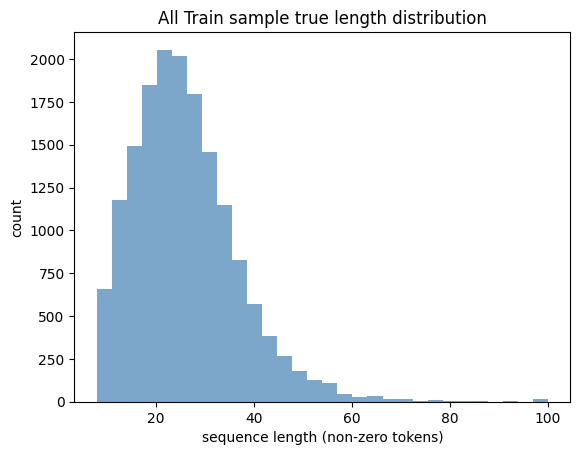

In [12]:
import matplotlib.pyplot as plt

def get_true_lengths(X, tol=1e-8):
    norms = np.linalg.norm(X, axis=2)
    nonzero_mask = norms > tol
    lengths = nonzero_mask.sum(axis=1)
    return lengths

train_lengths = get_true_lengths(X_all)

print("True Length Count：")
print("  min:", train_lengths.min())
print("  max:", train_lengths.max())
print("  mean:", train_lengths.mean())
print("  median:", np.median(train_lengths))

plt.hist(train_lengths, bins=30, alpha=0.7, color="steelblue")
plt.title("All Train sample true length distribution")
plt.xlabel("sequence length (non-zero tokens)")
plt.ylabel("count")
plt.show()

## Class Separation Analysis

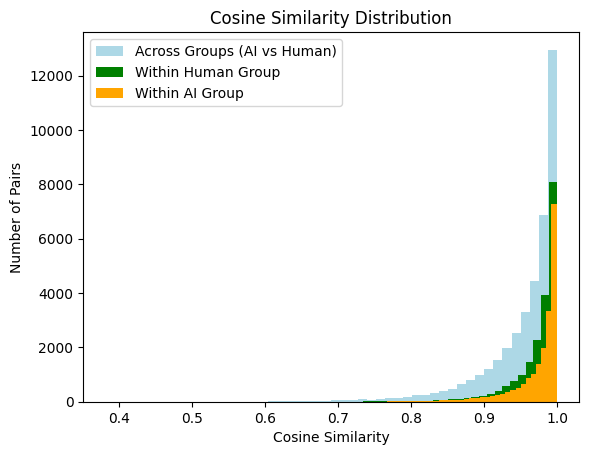

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

ai_sample = X_ai[:200].mean(axis=1)    # (200, 768)
hm_sample = X_human[:200].mean(axis=1) # (200, 768)

sim_ai_ai = cosine_similarity(ai_sample, ai_sample)
sim_hm_hm = cosine_similarity(hm_sample, hm_sample)
sim_ai_hm = cosine_similarity(ai_sample, hm_sample)

def upper_tri_flat(mat):
    return mat[np.triu_indices_from(mat, k=1)]

vals_ai_ai = upper_tri_flat(sim_ai_ai)
vals_hm_hm = upper_tri_flat(sim_hm_hm)
vals_ai_hm = sim_ai_hm.ravel()

plt.hist(vals_ai_hm, bins=50, alpha=1, label="Across Groups (AI vs Human)", color="lightblue")
plt.hist(vals_hm_hm, bins=50, alpha=1, label="Within Human Group", color="green")
plt.hist(vals_ai_ai, bins=50, alpha=1, label="Within AI Group", color="orange")

plt.legend()
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Pairs")
plt.show()

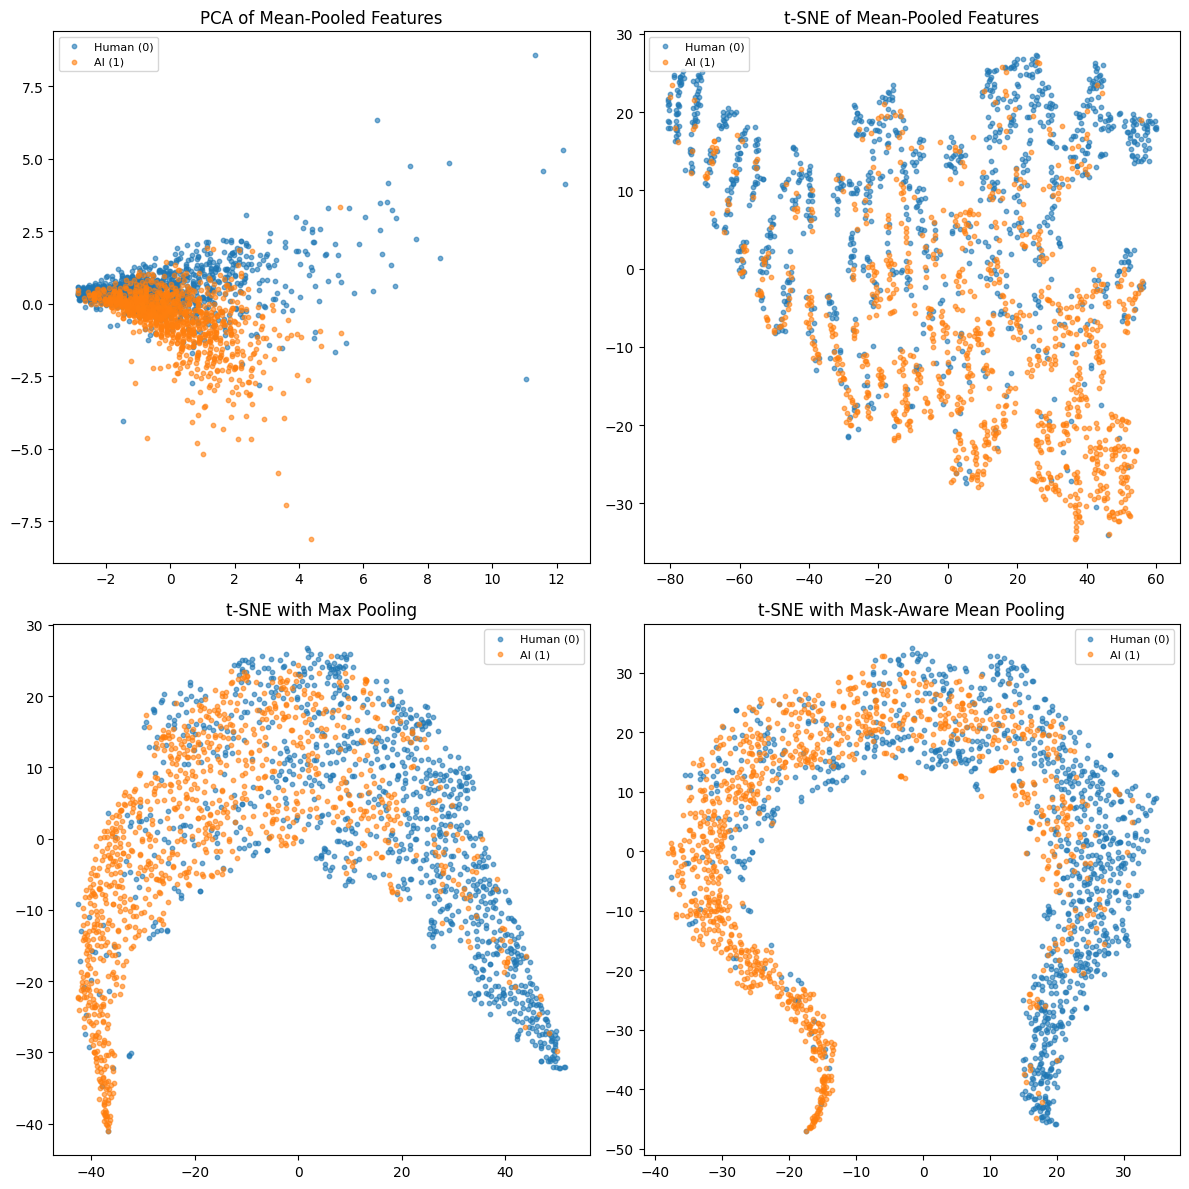

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ===== pooling functions =====
def mean_pool(X):
    return X.mean(axis=1)

def max_pool(X):
    return X.max(axis=1)

def mask_mean_pool(X):
    mask = (np.abs(X).sum(axis=-1) > 0).astype(np.float32)  # (N,L)
    valid_counts = mask.sum(axis=1, keepdims=True)
    valid_counts[valid_counts == 0] = 1
    return (X * mask[..., None]).sum(axis=1) / valid_counts

# ===== helper: sample 1000 AI + 1000 Human =====
def sample_data(X_pool, y_all, n=1000):
    X_sub = np.vstack([X_pool[y_all==1][:n], X_pool[y_all==0][:n]])
    y_sub = np.hstack([y_all[y_all==1][:n], y_all[y_all==0][:n]])
    return X_sub, y_sub

# ===== helper: plot =====
def scatter(ax, X_2d, y, title):
    ax.scatter(X_2d[y==0,0], X_2d[y==0,1], s=10, alpha=0.6, label="Human (0)")
    ax.scatter(X_2d[y==1,0], X_2d[y==1,1], s=10, alpha=0.6, label="AI (1)")
    ax.set_title(title)
    ax.legend(fontsize=8)

# ===== pooling & visualization =====
poolings = {
    "Mean": mean_pool,
    "Max": max_pool,
    "Mask-Aware Mean": mask_mean_pool
}

# choose which pooling strategies to show
selected = ["Mean", "Max", "Mask-Aware Mean"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# --- 1) PCA with Mean Pooling ---
X_pool = poolings["Mean"](X_all)
X_sub, y_sub = sample_data(X_pool, y_all)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_sub)
scatter(axes[0,0], X_pca, y_sub, "PCA of Mean-Pooled Features")

# --- 2) t-SNE with Mean Pooling ---
X_pool = poolings["Mean"](X_all)
X_sub, y_sub = sample_data(X_pool, y_all)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sub)
scatter(axes[0,1], X_tsne, y_sub, "t-SNE of Mean-Pooled Features")


# --- 3) t-SNE with Max Pooling ---
X_pool = poolings["Max"](X_all)
X_sub, y_sub = sample_data(X_pool, y_all)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sub)
scatter(axes[1,0], X_tsne, y_sub, "t-SNE with Max Pooling")

# --- 4) t-SNE with Mask-Aware Mean Pooling ---
X_pool = poolings["Mask-Aware Mean"](X_all)
X_sub, y_sub = sample_data(X_pool, y_all)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sub)
scatter(axes[1,1], X_tsne, y_sub, "t-SNE with Mask-Aware Mean Pooling")

plt.tight_layout()
plt.show()

## Comparison of Pooling Methods via Distance Metrics

In [15]:
from numpy.linalg import norm

# ===== distance & similarity =====
def compare_ai_human(X_all, y_all, pooling_fn):
    X_pool = pooling_fn(X_all)

    X_ai = X_pool[y_all == 1]
    X_hm = X_pool[y_all == 0]

    ai_mean = X_ai.mean(axis=0)
    hm_mean = X_hm.mean(axis=0)

    euclid_dist = norm(ai_mean - hm_mean)
    cos_sim = np.dot(ai_mean, hm_mean) / (norm(ai_mean) * norm(hm_mean))

    return euclid_dist, cos_sim

# ===== test different pooling =====
poolings = {
    "Mean": mean_pool,
    "Max": max_pool,
    "Mask-Aware Mean": mask_mean_pool
}
for name, fn in poolings.items():
    dist, sim = compare_ai_human(X_all, y_all, fn)
    print(f"{name} Pooling → Euc Distance: {dist:.4f}, Cosine Similarity: {sim:.4f}")

Mean Pooling → Euc Distance: 0.9933, Cosine Similarity: 0.9775
Max Pooling → Euc Distance: 2.2850, Cosine Similarity: 0.9880
Mask-Aware Mean Pooling → Euc Distance: 2.9162, Cosine Similarity: 0.9847


The validation set has uneven segment distributions across documents, making segment-level validation unreliable. We therefore rely on split-from-train monitoring for training evaluation.

## Checking Time-Step Patterns

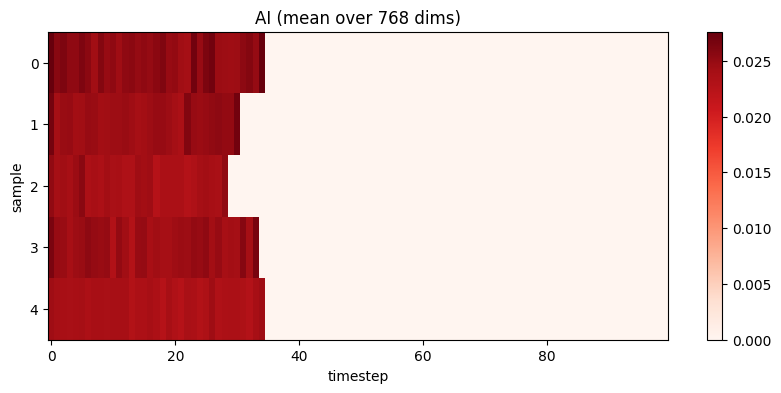

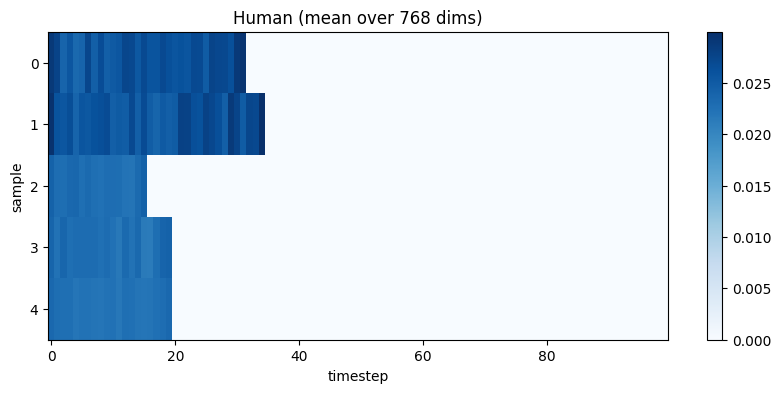

In [16]:
X_ai_time = X_all[y_all==1][:5].mean(axis=2)   # (5,100)
X_hm_time = X_all[y_all==0][:5].mean(axis=2)   # (5,100)

plt.figure(figsize=(10,4))
plt.imshow(X_ai_time, aspect="auto", cmap="Reds")
plt.colorbar(); plt.title("AI (mean over 768 dims)")
plt.xlabel("timestep"); plt.ylabel("sample")
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(X_hm_time, aspect="auto", cmap="Blues")
plt.colorbar(); plt.title("Human (mean over 768 dims)")
plt.xlabel("timestep"); plt.ylabel("sample")
plt.show()

## Analyze Validation Set Document Segment Distribution

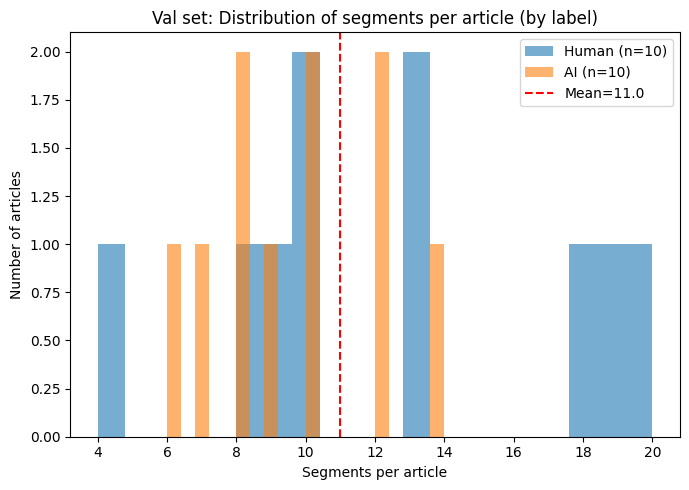

Overall Val Docs: 20
Human docs: 10, mean segs=12.40, median=11.5
AI docs: 10, mean segs=9.60, median=9.5


In [17]:
doc_labels = {}
doc_counts = {}

for uid in np.unique(val_ids):
    mask = (val_ids == uid)
    doc_counts[uid] = np.sum(mask)        # number of segments per document
    doc_labels[uid] = y_val_external[mask][0]  # document label (assume all segments share same label)

counts = np.array(list(doc_counts.values()))
labels = np.array(list(doc_labels.values()))

counts_0 = counts[labels == 0]
counts_1 = counts[labels == 1]

plt.figure(figsize=(7,5))
plt.hist(counts_0, bins=20, alpha=0.6, label=f"Human (n={len(counts_0)})")
plt.hist(counts_1, bins=20, alpha=0.6, label=f"AI (n={len(counts_1)})")
plt.axvline(counts.mean(), color="red", linestyle="--", label=f"Mean={counts.mean():.1f}")
plt.title("Val set: Distribution of segments per article (by label)")
plt.xlabel("Segments per article")
plt.ylabel("Number of articles")
plt.legend()
plt.tight_layout()
plt.show()

# ===== Print summary statistics =====
print("Overall Val Docs:", len(counts))
print(f"Human docs: {len(counts_0)}, mean segs={counts_0.mean():.2f}, median={np.median(counts_0)}")
print(f"AI docs: {len(counts_1)}, mean segs={counts_1.mean():.2f}, median={np.median(counts_1)}")

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):

    hist = history.history
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Loss ---
    axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if "accuracy" in hist:
        axes[1].plot(hist["accuracy"], label="train")
    if "val_accuracy" in hist:
        axes[1].plot(hist["val_accuracy"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # --- ROC AUC ---
    if "roc_auc" in hist:
        axes[2].plot(hist["roc_auc"], label="train")
    if "val_roc_auc" in hist:
        axes[2].plot(hist["val_roc_auc"], label="val")
    axes[2].set_title("ROC AUC")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("AUC")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Data Split and Training Preparation

We split the dataset into training (71%) and validation (29%) subsets (70/30 split (approx.)) with stratified sampling to maintain class balance, ensuring reliable model training and unbiased performance evaluation.

In [19]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter

def print_class_balance(y, name="set"):
    counter = Counter(y)
    total = len(y)
    print(f"{name} size: {total}")
    for cls, cnt in sorted(counter.items()):
        ratio = cnt / total
        print(f"  class {cls}: {cnt} ({ratio:.3f})")

In [20]:
X_all_shuffled, y_all_shuffled = shuffle(X_all, y_all, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_all_shuffled,
    y_all_shuffled,
    test_size=0.29,          # 30% for evalidation
    random_state=42,
    stratify=y_all_shuffled     # label balance
)

print("Train Shape:", X_train.shape, y_train.shape)
print("Val Shape:", X_val.shape, y_val.shape)
print_class_balance(y_train, "Train")
print_class_balance(y_val, "Val")

Train Shape: (11588, 100, 768) (11588,)
Val Shape: (4734, 100, 768) (4734,)
Train size: 11588
  class 0: 5794 (0.500)
  class 1: 5794 (0.500)
Val size: 4734
  class 0: 2367 (0.500)
  class 1: 2367 (0.500)


In [21]:
from sklearn.metrics import roc_auc_score, classification_report

def evaluate_model(model, X, y, ids=None, agg="mean", threshold=0.5, digits=3):
    """
    Evaluate a binary classification model at sample and document level.

    Args:
        model: Trained Keras model
        X: Input array (np.ndarray or tf.Tensor)
        y: True labels
        ids: Optional document IDs (to aggregate predictions)
        agg: Aggregation method for doc-level ('mean', 'max', 'vote')
        threshold: Classification threshold
        digits: Precision for classification report
    """

    # ---- Sequence (Sample) Level ----
    probs = model(X, training=False).numpy().ravel()   # instead of model.predict
    auc_sample = roc_auc_score(y, probs)
    preds = (probs > threshold).astype(int)

    print("Sample-level AUROC:", round(auc_sample, 4))
    print("Classification Report (sample-level):")
    print(classification_report(y, preds, digits=digits))

    # ---- Document Level ----
    if ids is not None and agg is not None:
        doc_probs = {}
        doc_labels = {}
        for p, yy, i in zip(probs, y, ids):
            doc_probs.setdefault(i, []).append(p)
            doc_labels[i] = yy

        if agg == "mean":
            doc_probs = {i: np.mean(v) for i, v in doc_probs.items()}
        elif agg == "max":
            doc_probs = {i: np.max(v) for i, v in doc_probs.items()}
        elif agg == "vote":
            doc_probs = {i: float(np.mean(v) > 0.5) for i, v in doc_probs.items()}
        else:
            raise ValueError("agg must be 'mean' | 'max' | 'vote'")

        doc_probs = np.array(list(doc_probs.values()))
        doc_labels = np.array(list(doc_labels.values()))
        auc_doc = roc_auc_score(doc_labels, doc_probs)

        print(f"Doc-level AUROC ({agg}):", round(auc_doc, 4))

The function evaluates the model at two levels:

Sample-level: classifies each slice, reporting AUROC and metrics with a fixed threshold.

Document-level: aggregates slice predictions (mean, max, or vote) per document and computes AUROC.

This checks both slice-level and overall document accuracy.

# Initial Model Selection

We compare three lightweight models for AI–Human classification: MLP (adds non-linear transformations for modest complexity gains), TextCNN (captures local n-gram–like patterns efficiently), and BiGRU (models temporal dependencies with relatively few parameters). Together, they cover feed-forward, convolutional, and recurrent approaches, enabling a balanced comparison before selecting one for tuning.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es_selection = EarlyStopping(
    monitor="val_loss",      # monitor validation roc_auc
    patience=3,            # stop if no improvement after 5 epochs
    restore_best_weights=True,    # restore model weights from the best epoch
)

## Multi-Layer Perceptron (MLP) Classifier with Mask-aware Mean Pooling

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers as reg

def build_mlp(
    input_shape=(100, 768),
    hidden1=64,            # first hidden layer
    hidden2=32,             # second hidden layer
    dropout1=0.4,
    dropout2=0.2,
    l2_reg=1e-4,
    learning_rate=2e-4,
    label_smoothing=0.01,
    clipnorm=1.0,
    optimizer="adam"
):
    """Factory function for 2-layer MLP (mask-aware pooling + 2 Dense layers)."""

    # ---- Input & mask ----
    inp  = layers.Input(shape=input_shape, dtype="float32")
    mask = layers.Lambda(lambda t: tf.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)

    # ---- Mask-aware mean pooling -> (B, D) ----
    pooled = layers.Lambda(
        lambda a: tf.reduce_sum(a[0] * tf.cast(a[1][..., None], tf.float32), axis=1) /
                  tf.clip_by_value(tf.reduce_sum(tf.cast(a[1][..., None], tf.float32), axis=1), 1., 1e9)
    )([inp, mask])

    # ---- MLP head ----
    x = pooled

    # First Dense
    x = layers.Dense(hidden1, activation="relu",
                     kernel_regularizer=reg.l2(l2_reg))(x)
    x = layers.Dropout(dropout1)(x)
    # Second Dense
    x = layers.Dense(hidden2, activation="relu",
                     kernel_regularizer=reg.l2(l2_reg))(x)
    x = layers.Dropout(dropout2)(x)

    # Output
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = models.Model(inp, out)

    # ---- Optimizer setup ----
    if isinstance(optimizer, str):
        if optimizer.lower() == "adam":
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
        elif optimizer.lower() == "adamw":
            opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=clipnorm)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
    else:
        opt = optimizer

    # ---- Compile model ----
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")],
    )
    return model

In [24]:
set_seed(42)

mlp_clf = build_mlp()

mlp_clf.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 768)       │          0 │ input_layer[0][0… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

It is a 2-layer MLP classifier: masked mean pooling reduces the input sequence to a 768-dim vector, followed by Dense layers of 64 and 32 units with dropout, and a final sigmoid output for binary classification.

In [25]:
history1 = mlp_clf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es_selection],
    verbose=0
)

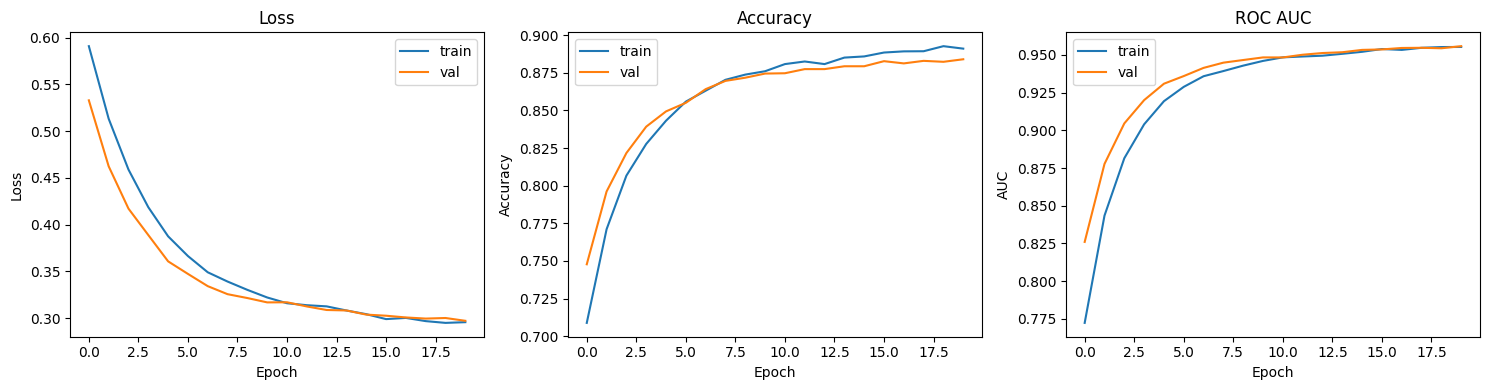

In [26]:
plot_history(history1)

In [27]:
evaluate_model(model=mlp_clf, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

Sample-level AUROC: 0.7822
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.695     0.847     0.764       124
           1      0.725     0.521     0.606        96

    accuracy                          0.705       220
   macro avg      0.710     0.684     0.685       220
weighted avg      0.708     0.705     0.695       220

Doc-level AUROC (mean): 0.94


## TextCNN Classifier with Global Max Pooling

In [28]:
def build_textcnn(
    input_shape=(100, 768),
    num_filters=16,
    kernel_sizes=(3,5,),
    dense_units=16,
    dropout=0.3,
    l2_reg=1e-4,
    learning_rate=3e-5,
    label_smoothing=0.01,
    clipnorm=1.0,
    optimizer="adam"
):

    # ---- Input ----
    inp = layers.Input(shape=input_shape, dtype="float32")

    # ---- Multiple Conv1D + SpatialDropout + GlobalMaxPooling ----
    convs = []
    for k in kernel_sizes:
        c = layers.Conv1D(
            filters=num_filters,
            kernel_size=k,
            activation="relu",
            kernel_regularizer=reg.l2(l2_reg),
            padding="valid"
        )(inp)
        c = layers.SpatialDropout1D(0.2)(c)   # extra regularization
        p = layers.GlobalMaxPooling1D()(c)    # (B, num_filters)
        convs.append(p)

    # Concatenate pooled features
    x = layers.Concatenate()(convs) if len(convs) > 1 else convs[0]

    # ---- Dense head ----
    x = layers.Dense(dense_units, activation="relu",
                     kernel_regularizer=reg.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)   # stabilize training
    x = layers.Dropout(dropout)(x)

    # Output
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = models.Model(inp, out)

    # ---- Optimizer setup ----
    if isinstance(optimizer, str):
        if optimizer.lower() == "adam":
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
        elif optimizer.lower() == "adamw":
            opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=clipnorm)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
    else:
        opt = optimizer

    # ---- Compile ----
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")]
    )
    return model

In [29]:
set_seed(42)

textcnn = build_textcnn()
textcnn.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 16)    │     36,880 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 16)    │     61,456 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 98, 16)    │          0 │ conv1d[0][0]      │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 96, 16)    │          0 │ conv1d_1[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 16)        │          0 │ spatial_dropout1… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 16)        │          0 │ spatial_dropout1… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16)        │         64 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,945 (386.50 KB)

 Trainable params: 98,913 (386.38 KB)

 Non-trainable params: 32 (128.00 B)

In [30]:
history2 = textcnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es_selection],
    verbose=0
)

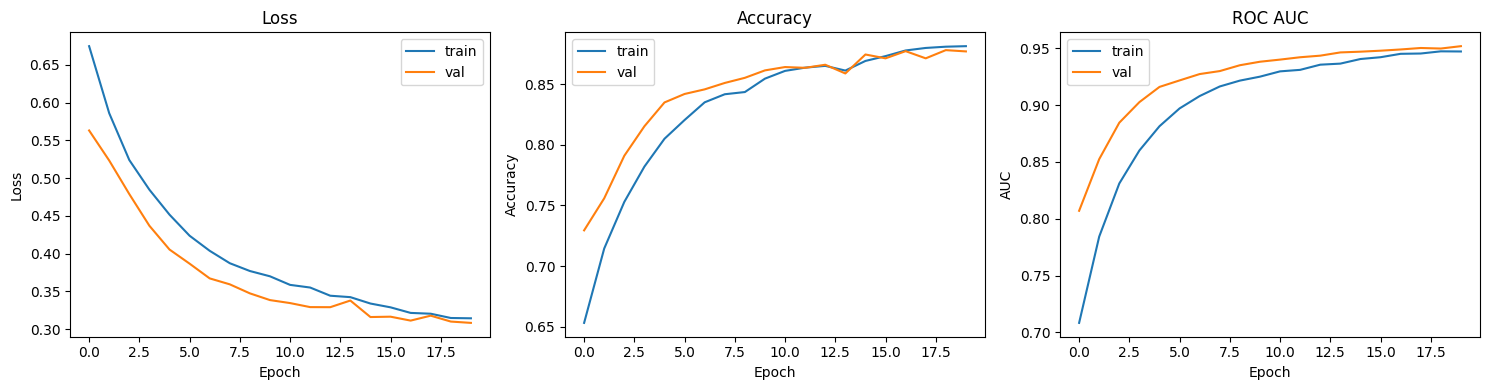

In [31]:
plot_history(history2)

In [32]:
evaluate_model(model=textcnn, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

Sample-level AUROC: 0.7717
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.701     0.871     0.777       124
           1      0.758     0.521     0.617        96

    accuracy                          0.718       220
   macro avg      0.729     0.696     0.697       220
weighted avg      0.726     0.718     0.707       220

Doc-level AUROC (mean): 0.94


## Bidirectional GRU Classifier with Multi-Head Attention and Mask-aware Mean Pooling

In [33]:
def build_bigru_light(
    input_shape=(100, 768),
    gru_units=32,
    gru_dropout=0.2,
    mha_heads=4,
    mha_keydim=16,
    mha_dropout=0.1,
    dense_units=64,
    dense_dropout=0.4,
    l2_reg=1e-4,
    learning_rate=2e-4,
    label_smoothing=0.01,
    clipnorm=1.0,
    optimizer="adam"
):
    """Factory function for BiGRU+Attention model with flexible optimizer."""

    # ---- input & mask ----
    inp  = layers.Input(shape=input_shape, dtype="float32")
    mask = layers.Lambda(lambda t: tf.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)

    # ---- BiGRU ----
    x = layers.Bidirectional(
            layers.GRU(gru_units, return_sequences=True,
                       dropout=gru_dropout, recurrent_dropout=0.0)
        )(inp, mask=mask)

    # ---- Multi-Head Attention ----
    attn = layers.MultiHeadAttention(
        num_heads=mha_heads, key_dim=mha_keydim, dropout=mha_dropout
    )(x, x, attention_mask=mask[:, None, None, :])

    # Residual + Norm + Dropout
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)
    x = layers.SpatialDropout1D(gru_dropout / 2)(x)

    # ---- Mask-aware mean pooling ----
    pooled = layers.Lambda(
        lambda args: tf.reduce_sum(args[0] * tf.cast(args[1][..., None], tf.float32), axis=1) /
                     tf.clip_by_value(tf.reduce_sum(tf.cast(args[1][..., None], tf.float32), axis=1), 1., 1e9)
    )([x, mask])

    # ---- Dense head ----
    h = layers.Dense(dense_units, activation="relu",
                     kernel_regularizer=reg.l2(l2_reg))(pooled)
    h = layers.Dropout(dense_dropout)(h)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(h)

    model = models.Model(inp, out)

    # ---- Optimizer selection ----
    if optimizer.lower() == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    elif optimizer.lower() == "adamw":
        opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=clipnorm)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    # ---- Compile ----
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")]
    )
    return model

In [34]:
set_seed(42)

bigru_light = build_bigru_light()

bigru_light.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 100)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 64)   │    153,984 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 1, 1, 100) │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     16,640 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
│                     │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ bidirectional[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 100, 64)   │          0 │ layer_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 64)        │          0 │ spatial_dropout1… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,977 (683.50 KB)

 Trainable params: 174,977 (683.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history3 = bigru_light.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es_selection],
    verbose=0
)

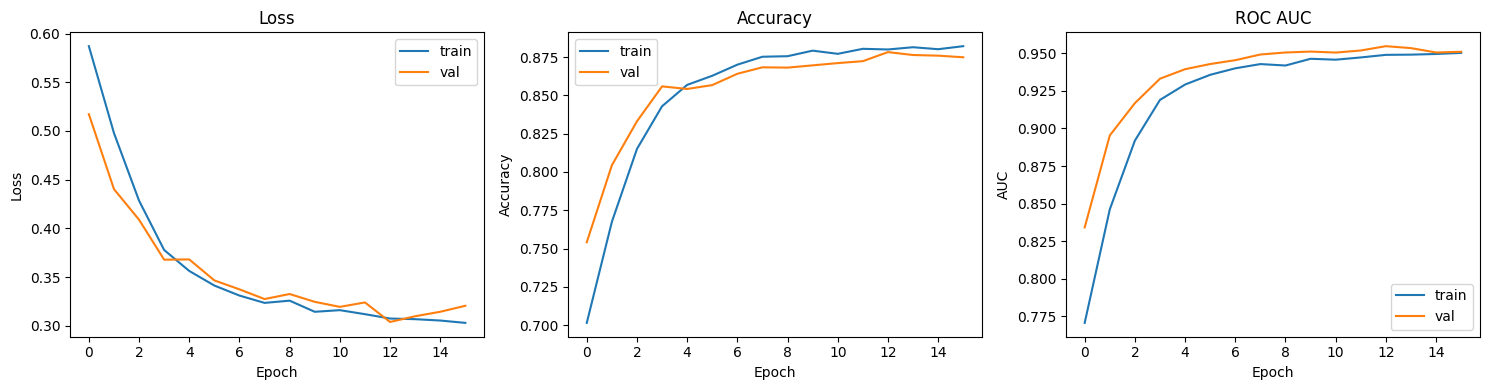

In [36]:
plot_history(history3)

In [37]:
evaluate_model(model=bigru_light, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

Sample-level AUROC: 0.7651
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.713     0.782     0.746       124
           1      0.679     0.594     0.633        96

    accuracy                          0.700       220
   macro avg      0.696     0.688     0.690       220
weighted avg      0.698     0.700     0.697       220

Doc-level AUROC (mean): 0.92


Based on the validation convergence results, we selected BiGRU and MLP for further optimization and comparison. BiGRU showed stable sequence modeling performance, while MLP achieved fast convergence with competitive validation metrics. Therefore, these two models were chosen as the focus for parameter tuning.

In [38]:
def plot_history_dict(hist, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Loss ---
    axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if "accuracy" in hist:
        axes[1].plot(hist["accuracy"], label="train")
    if "val_accuracy" in hist:
        axes[1].plot(hist["val_accuracy"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # --- ROC AUC ---
    if "roc_auc" in hist:
        axes[2].plot(hist["roc_auc"], label="train")
    if "val_roc_auc" in hist:
        axes[2].plot(hist["val_roc_auc"], label="val")
    axes[2].set_title("ROC AUC")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("AUC")
    axes[2].legend()

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

In [39]:
def evaluate_model_1(model, X, y, ids=None, agg="mean", threshold=0.5, digits=3):
    """
    Evaluate a binary classification model at both sample and document level.

    Args:
        model: Trained Keras model
        X: Input array (np.ndarray or tf.Tensor)
        y: True labels (array-like)
        ids: Optional document IDs (to aggregate predictions)
        agg: Aggregation method for doc-level ('mean', 'max', 'vote')
        threshold: Classification threshold
        digits: Precision for classification report
    Returns:
        results: dict with sample-level and (optional) doc-level metrics
    """

    results = {}

    # ---- Sample Level ----
    probs = model(X, training=False).numpy().ravel()
    auc_sample = roc_auc_score(y, probs)

    results["auc_sample"] = auc_sample

    # ---- Document Level ----
    if ids is not None and agg is not None:
        doc_probs = {}
        doc_labels = {}
        for p, yy, i in zip(probs, y, ids):
            doc_probs.setdefault(i, []).append(p)
            doc_labels[i] = yy

        if agg == "mean":
            doc_probs = {i: np.mean(v) for i, v in doc_probs.items()}
        elif agg == "max":
            doc_probs = {i: np.max(v) for i, v in doc_probs.items()}
        elif agg == "vote":
            doc_probs = {i: float(np.mean(v) > 0.5) for i, v in doc_probs.items()}
        else:
            raise ValueError("agg must be 'mean' | 'max' | 'vote'")

        doc_probs = np.array(list(doc_probs.values()))
        doc_labels = np.array(list(doc_labels.values()))

        auc_doc = roc_auc_score(doc_labels, doc_probs)

        results["auc_doc"] = auc_doc

    return results

# MLP Model Optimization

In [40]:
es_mlp = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

## Optimizer & LR Search

In [41]:
search_space1_mlp = [
    ("adam",   2e-4),
    ("adam",   3e-4),
    ("adamw",  2.5e-4)
]

results1_mlp = []
histories1_mlp = {}

In [42]:
for opt, lr in search_space1_mlp:

    print(f"\n===== Testing optimizer={opt}, lr={lr} =====")

    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        learning_rate=lr,
        optimizer=opt
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_mlp]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results1_mlp.append((opt, lr, res["auc_sample"], res.get("auc_doc")))
    histories1_mlp[(opt, lr)] = history.history


===== Testing optimizer=adam, lr=0.0002 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing optimizer=adam, lr=0.0003 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing optimizer=adamw, lr=0.00025 =====
[INFO] Seed set to 42, deterministic ops enabled


In [43]:
results1_mlp_sorted = sorted(results1_mlp, key=lambda x: x[3], reverse=True)

print("\n===== Summary of Optimizer & LR Search =====")
for opt, lr, auc_s, auc_d in results1_mlp_sorted:
    print(f"optimizer={opt:7s}, lr={lr:.1e}  ->  "
          f"val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")


===== Summary of Optimizer & LR Search =====
optimizer=adam   , lr=2.0e-04  ->  val_auc_sample=0.7822, val_auc_doc=0.9400
optimizer=adam   , lr=3.0e-04  ->  val_auc_sample=0.7832, val_auc_doc=0.9400
optimizer=adamw  , lr=2.5e-04  ->  val_auc_sample=0.7831, val_auc_doc=0.9400


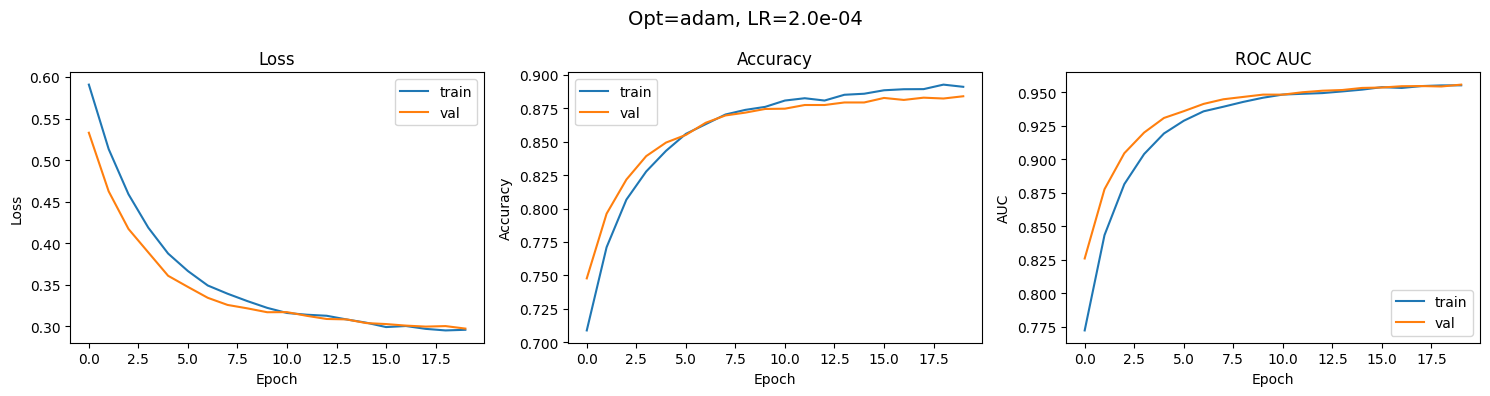

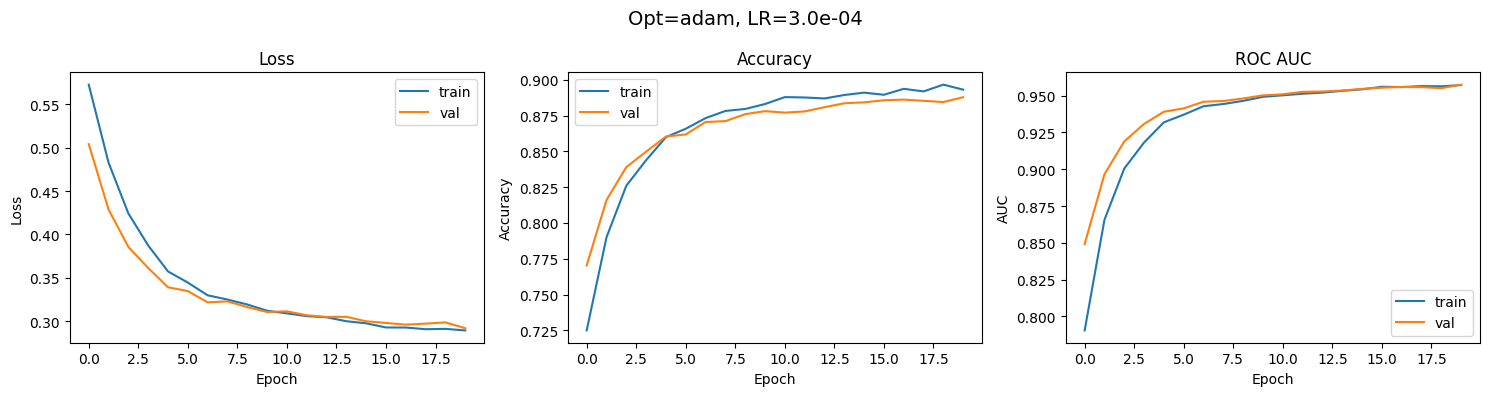

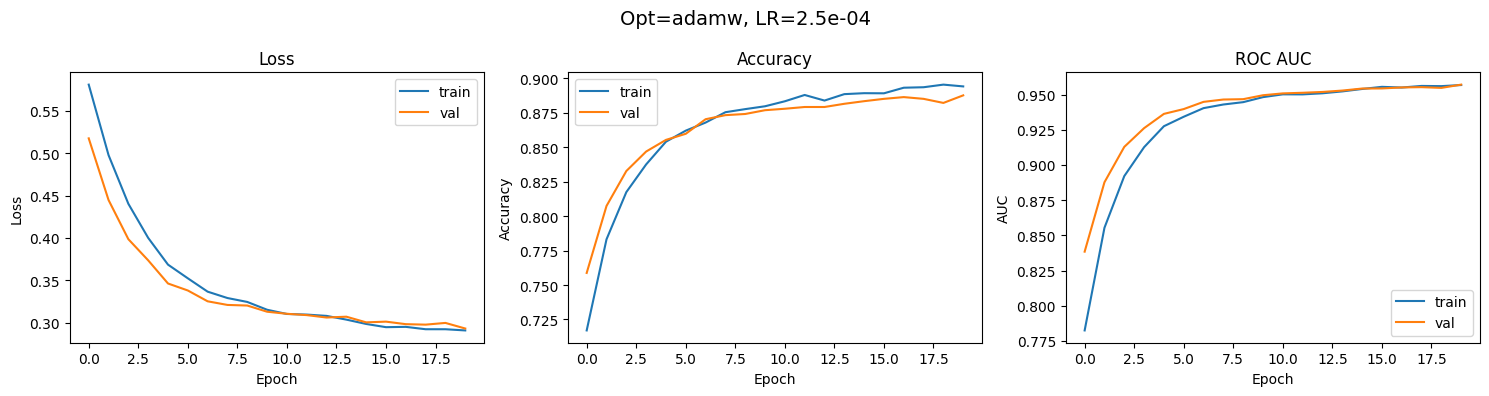

In [44]:
for (opt, lr), hist in histories1_mlp.items():
    title = f"Opt={opt}, LR={lr:.1e}"
    plot_history_dict(hist, title=title)

## Model Capacity Search

In [45]:
best_mlp_opt = "adam"
best_mlp_lr = 3e-4

In [46]:
search_space2_mlp = [
    (32, 16),
    (64, 32),
    (128, 64)
]

results2_mlp = []
histories2_mlp = {}

In [47]:
for h1, h2 in search_space2_mlp:

    print(f"\n===== Testing hidden1={h1}, hidden2={h2} =====")

    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=h1,
        hidden2=h2,
        learning_rate=best_mlp_lr,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_mlp]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results2_mlp.append((h1, h2, res["auc_sample"], res.get("auc_doc")))
    histories2_mlp[(h1, h2)] = history.history


===== Testing hidden1=32, hidden2=16 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing hidden1=64, hidden2=32 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing hidden1=128, hidden2=64 =====
[INFO] Seed set to 42, deterministic ops enabled


In [48]:
results2_mlp_sorted = sorted(results2_mlp, key=lambda x: x[3], reverse=True)

print("\n===== Summary of Capacity Search =====")
for h1, h2, auc_s, auc_d in results2_mlp_sorted:
    print(f"hidden1={h1:3d}, hidden2={h2:3d}  ->  "
          f"val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")


===== Summary of Capacity Search =====
hidden1=128, hidden2= 64  ->  val_auc_sample=0.7820, val_auc_doc=0.9500
hidden1= 64, hidden2= 32  ->  val_auc_sample=0.7832, val_auc_doc=0.9400
hidden1= 32, hidden2= 16  ->  val_auc_sample=0.7757, val_auc_doc=0.9300


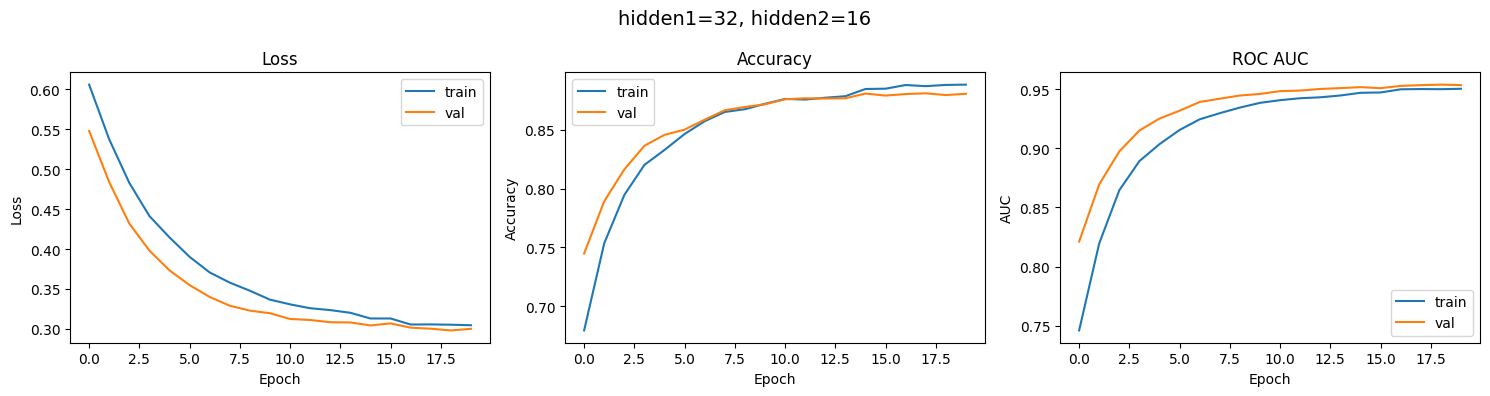

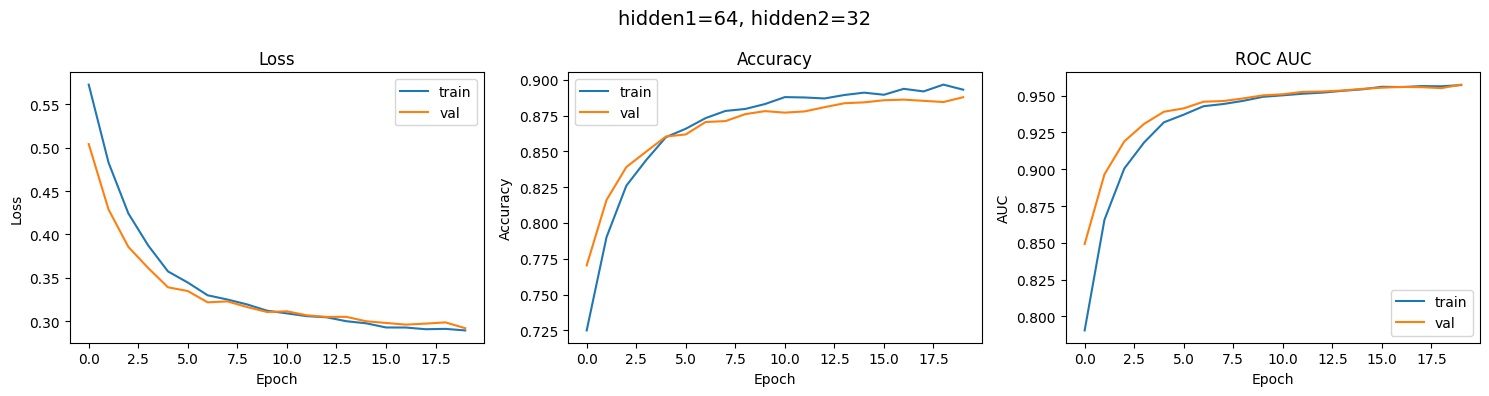

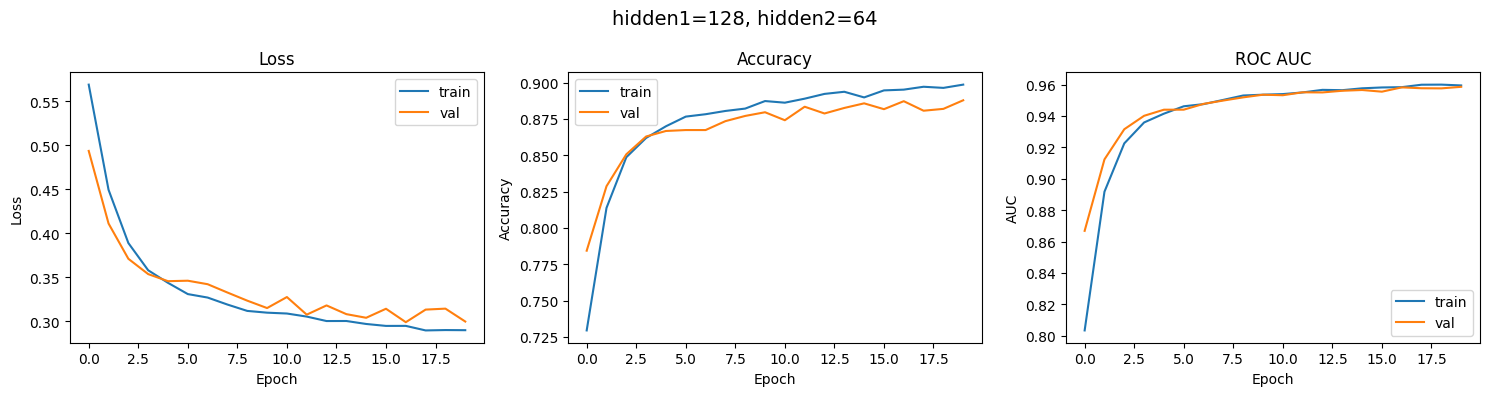

In [49]:
for (h1, h2), hist in histories2_mlp.items():
    title = f"hidden1={h1}, hidden2={h2}"
    plot_history_dict(hist, title=title)

## Regularization Search

In [50]:
best_hidden1 = 64
best_hidden2 = 32

In [51]:
search_space3_mlp = [
    (0.3, 0.15, 5e-5),   # lighter regularization
    (0.4, 0.2, 1e-4),    # baseline
    (0.5, 0.25, 5e-4),   # stronger dropout + L2
    (0.5, 0.25, 1e-3)    # strongest regularization
]

results3_mlp = []
histories3_mlp = {}

In [52]:
for d1, d2, l2reg in search_space3_mlp:

    print(f"\n===== Testing dropout1={d1}, dropout2={d2}, L2={l2reg} =====")

    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hidden1,
        hidden2=best_hidden2,
        dropout1=d1,
        dropout2=d2,
        l2_reg=l2reg,
        learning_rate=best_mlp_lr,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_mlp]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results3_mlp.append((d1, d2, l2reg, res["auc_sample"], res.get("auc_doc")))
    histories3_mlp[(d1, d2, l2reg)] = history.history


===== Testing dropout1=0.3, dropout2=0.15, L2=5e-05 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing dropout1=0.4, dropout2=0.2, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing dropout1=0.5, dropout2=0.25, L2=0.0005 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing dropout1=0.5, dropout2=0.25, L2=0.001 =====
[INFO] Seed set to 42, deterministic ops enabled


In [53]:
results3_mlp_sorted = sorted(results3_mlp, key=lambda x: x[4], reverse=True)

print("\n===== Summary of Regularization Search =====")
for d1, d2, l2reg, auc_s, auc_d in results3_mlp_sorted:
    print(f"dropout1={d1:.2f}, dropout2={d2:.2f}, L2={l2reg:.0e}  ->  "
          f"val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")


===== Summary of Regularization Search =====
dropout1=0.50, dropout2=0.25, L2=5e-04  ->  val_auc_sample=0.7809, val_auc_doc=0.9500
dropout1=0.30, dropout2=0.15, L2=5e-05  ->  val_auc_sample=0.7826, val_auc_doc=0.9400
dropout1=0.40, dropout2=0.20, L2=1e-04  ->  val_auc_sample=0.7832, val_auc_doc=0.9400
dropout1=0.50, dropout2=0.25, L2=1e-03  ->  val_auc_sample=0.7745, val_auc_doc=0.9300


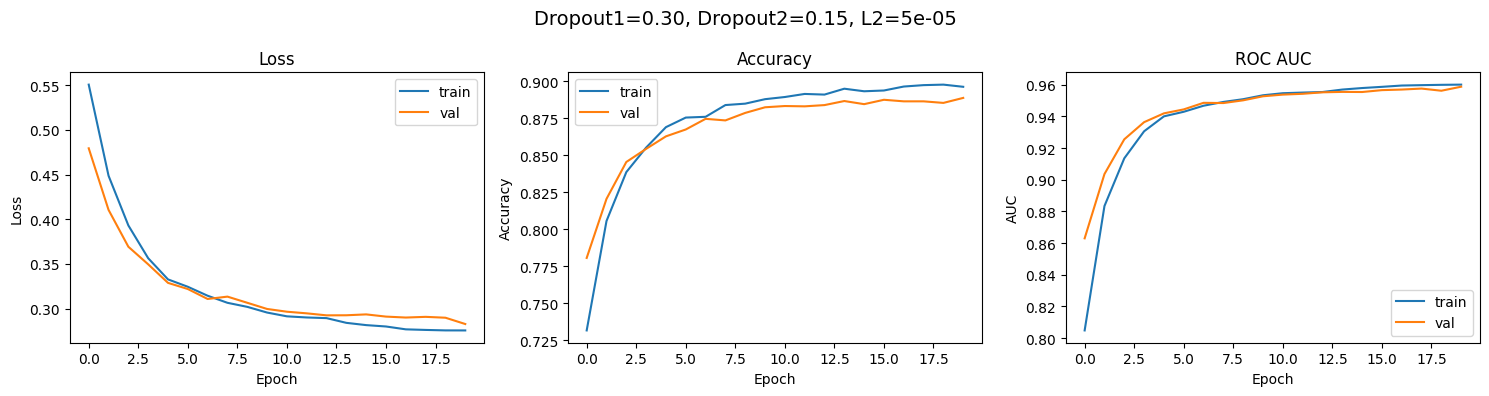

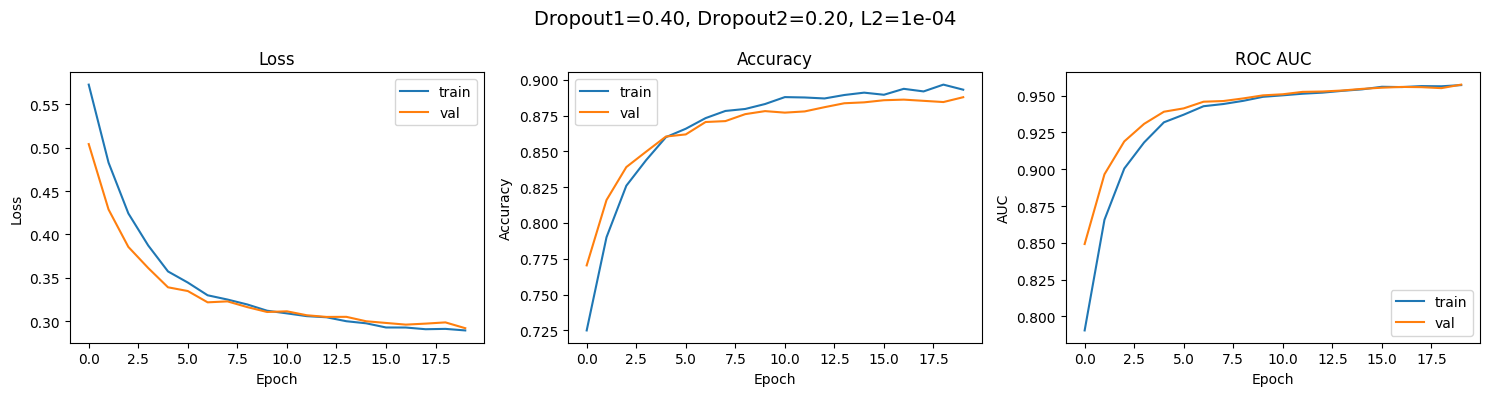

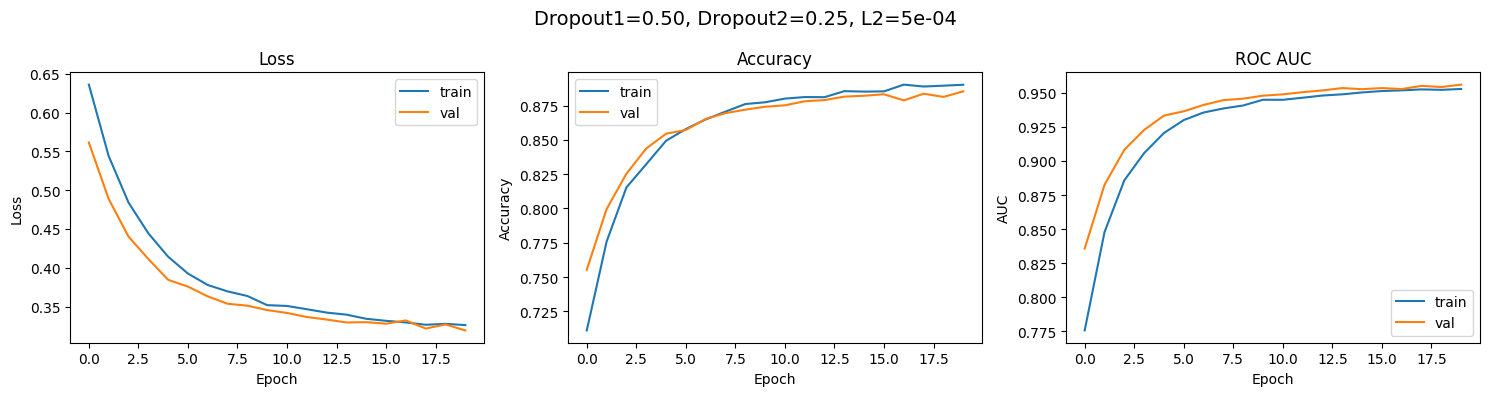

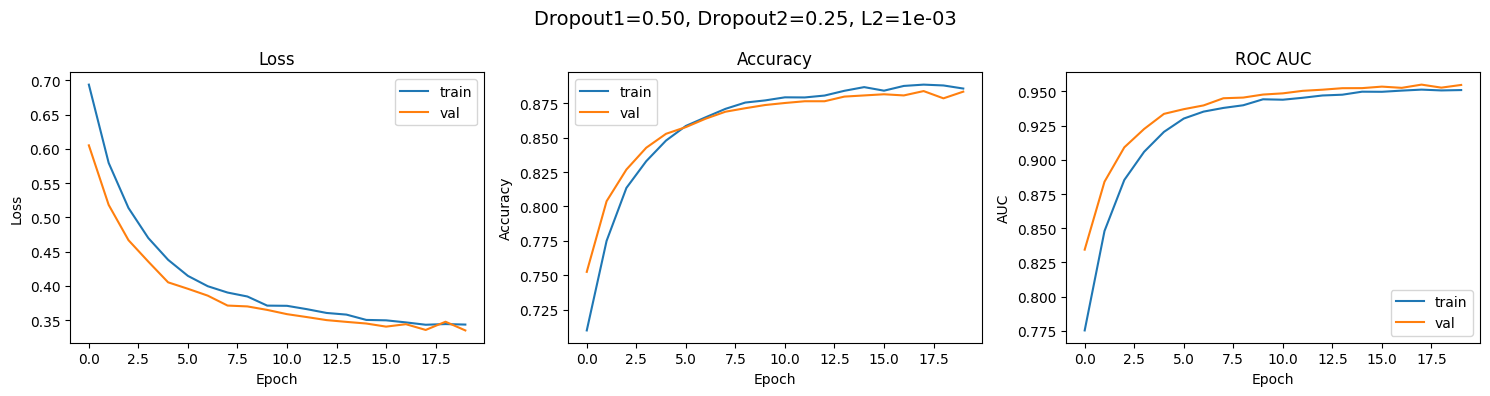

In [54]:
for (d1, d2, l2reg), hist in histories3_mlp.items():
    title = f"Dropout1={d1:.2f}, Dropout2={d2:.2f}, L2={l2reg:.0e}"
    plot_history_dict(hist, title=title)

## Label Smoothing Search

In [55]:
best_mlp_dropout1 = 0.5
best_mlp_dropout2 = 0.25
best_mlp_l2_reg = 5e-4

In [56]:
search_space4_mlp = [0.01, 0.1]

results4_mlp = []
histories4_mlp = {}

In [57]:
for ls in search_space4_mlp:

    print(f"\n===== Testing Label Smoothing={ls} =====")

    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hidden1,
        hidden2=best_hidden2,
        dropout1=best_mlp_dropout1,
        dropout2=best_mlp_dropout2,
        l2_reg=best_mlp_l2_reg,
        learning_rate=best_mlp_lr,
        label_smoothing=ls,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_mlp]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results4_mlp.append((ls, res["auc_sample"], res.get("auc_doc")))
    histories4_mlp[ls] = history.history


===== Testing Label Smoothing=0.01 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing Label Smoothing=0.1 =====
[INFO] Seed set to 42, deterministic ops enabled


In [58]:
print("\n===== Summary: Label Smoothing Test =====")

results4_mlp_sorted = sorted(results4_mlp, key=lambda x: x[2], reverse=True)
for ls, auc_s, auc_d in results4_mlp_sorted:
    print(f"LabelSmoothing={ls:.2f}  ->  val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")


===== Summary: Label Smoothing Test =====
LabelSmoothing=0.01  ->  val_auc_sample=0.7809, val_auc_doc=0.9500
LabelSmoothing=0.10  ->  val_auc_sample=0.7813, val_auc_doc=0.9500


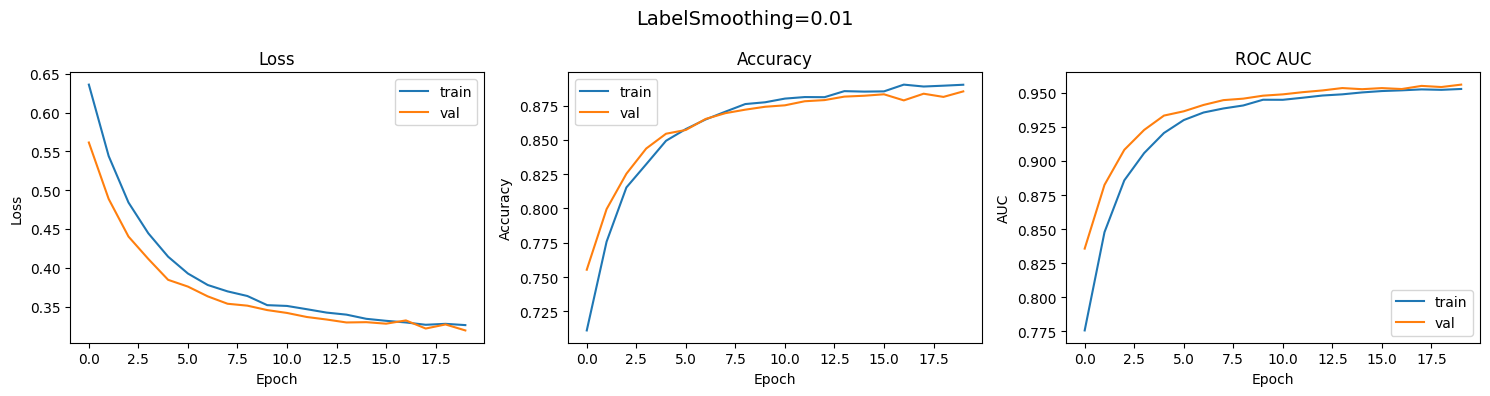

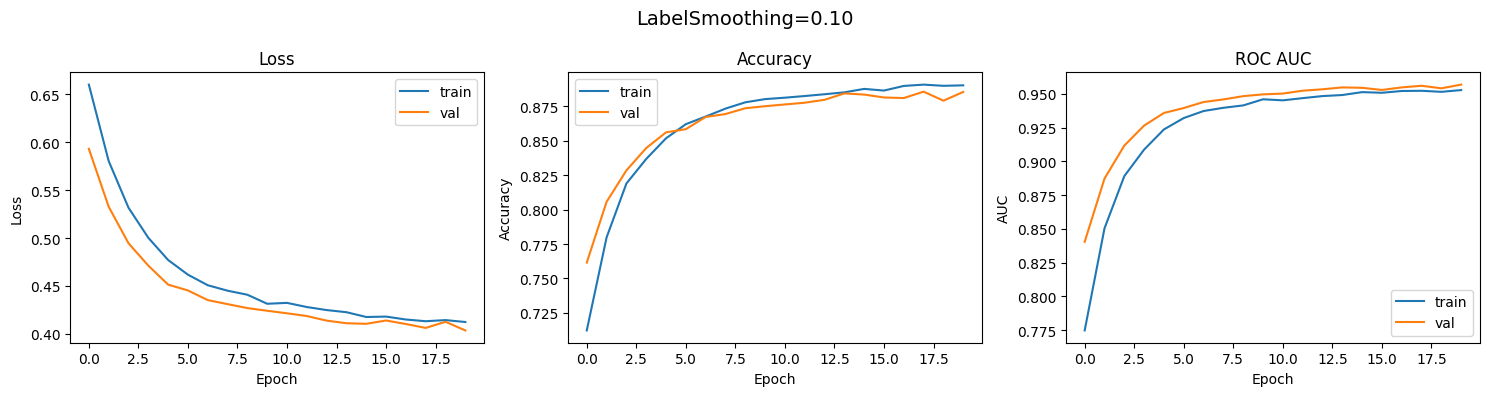

In [59]:
for ls, hist in histories4_mlp.items():
    title = f"LabelSmoothing={ls:.2f}"
    plot_history_dict(hist, title=title)

## Callbacks with Larger Early Stop Patience and LRreducer

In [60]:
best_mlp_ls = 0.1

In [61]:
cb_reduceLR = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
    )
]

cb_es = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

In [62]:
callback_sets_mlp = {
    "earlystop_5": cb_es,
    "reduceLR+earlystop": cb_reduceLR
}

results5_mlp = []
histories5_mlp = {}

In [63]:
for name, cb in callback_sets_mlp.items():

    print(f"\n===== Testing callbacks: {name} =====")

    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hidden1,
        hidden2=best_hidden2,
        dropout1=best_mlp_dropout1,
        dropout2=best_mlp_dropout2,
        l2_reg=best_mlp_l2_reg,
        learning_rate=best_mlp_lr,
        label_smoothing=best_mlp_ls,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=cb
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results5_mlp.append((name, res["auc_sample"], res.get("auc_doc")))
    histories5_mlp[name] = history.history


===== Testing callbacks: earlystop_5 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing callbacks: reduceLR+earlystop =====
[INFO] Seed set to 42, deterministic ops enabled


In [64]:
results5_mlp_sorted = sorted(results5_mlp, key=lambda x: x[2], reverse=True)
for name, auc_s, auc_d in results5_mlp_sorted:
    print(f"{name:15s} -> val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")

earlystop_5     -> val_auc_sample=0.7861, val_auc_doc=0.9500
reduceLR+earlystop -> val_auc_sample=0.7903, val_auc_doc=0.9500


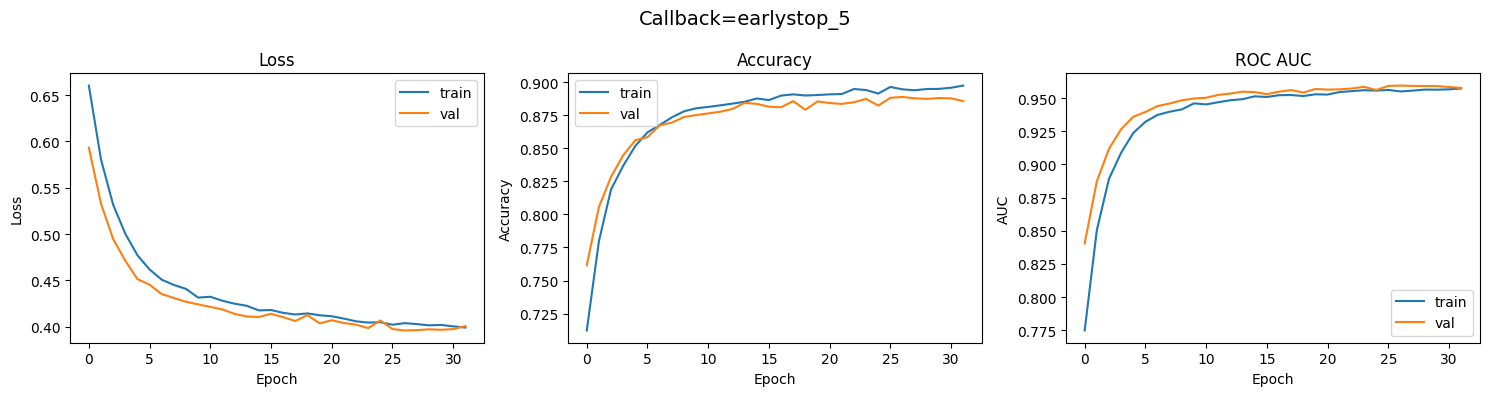

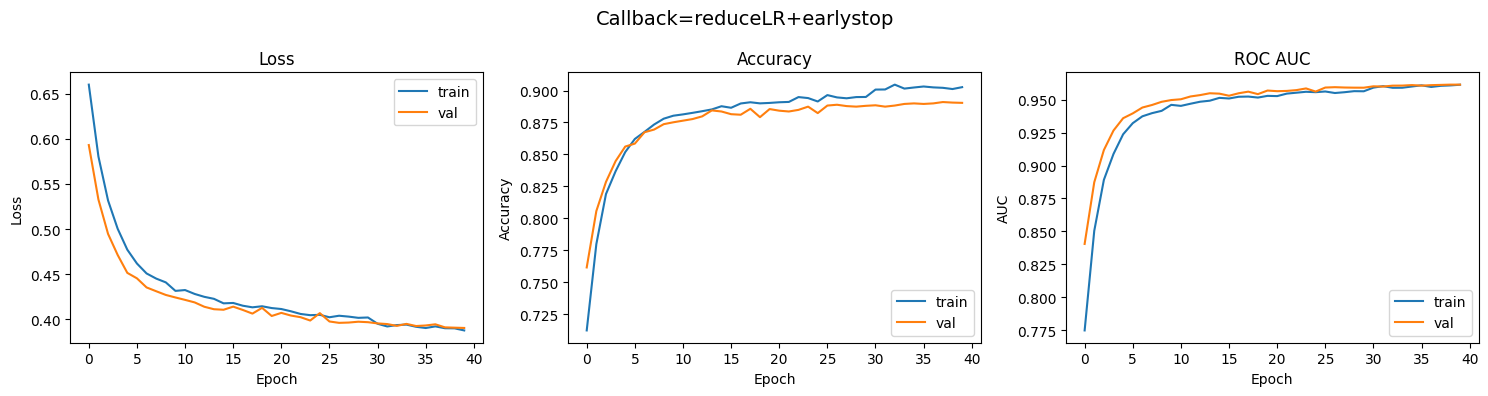

In [65]:
for name, hist in histories5_mlp.items():
    plot_history_dict(hist, title=f"Callback={name}")

# Final MLP Model Training and Evaluation

In [66]:
def print_best_config(name, config_dict):
    print(f"\n===== Best {name} Config =====")
    for k, v in config_dict.items():
        print(f"{k:15s}: {v}")

In [67]:
best_mlp_es = callback_sets_mlp["earlystop_5"]

In [68]:
best_config_mlp = {
    "hidden1": best_hidden1,
    "hidden2": best_hidden2,
    "dropout1": best_mlp_dropout1,
    "dropout2": best_mlp_dropout2,
    "l2_reg": best_mlp_l2_reg,
    "learning_rate": best_mlp_lr,
    "label_smoothing": best_mlp_ls,
    "optimizer": best_mlp_opt,
}

In [69]:
print_best_config("MLP", best_config_mlp)


===== Best MLP Config =====
hidden1        : 64
hidden2        : 32
dropout1       : 0.5
dropout2       : 0.25
l2_reg         : 0.0005
learning_rate  : 0.0003
label_smoothing: 0.1
optimizer      : adam


In [70]:
set_seed(42)

final_mlp = build_mlp(
    input_shape=(100, 768),
    hidden1=best_hidden1,
    hidden2=best_hidden2,
    dropout1=best_mlp_dropout1,
    dropout2=best_mlp_dropout2,
    l2_reg=best_mlp_l2_reg,
    learning_rate=best_mlp_lr,
    label_smoothing=best_mlp_ls,
    optimizer=best_mlp_opt
)

final_mlp.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_32 (Lambda)  │ (None, 100)       │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_33 (Lambda)  │ (None, 768)       │          0 │ input_layer_17[0… │
│                     │                   │            │ lambda_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 64)        │     49,216 │ lambda_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64)        │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 32)        │      2,080 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 32)        │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 1)         │         33 │ dropout_34[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_mlp = final_mlp.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,
    verbose=0,
    callbacks=best_mlp_es
)

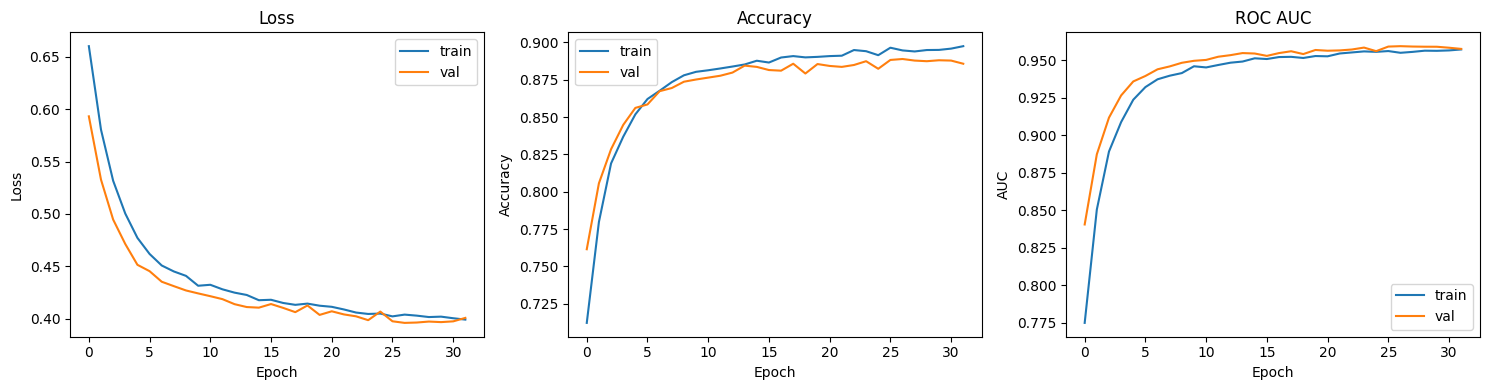

In [72]:
plot_history(history_mlp)

In [73]:
evaluate_model(model=final_mlp, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

Sample-level AUROC: 0.7861
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.695     0.847     0.764       124
           1      0.725     0.521     0.606        96

    accuracy                          0.705       220
   macro avg      0.710     0.684     0.685       220
weighted avg      0.708     0.705     0.695       220

Doc-level AUROC (mean): 0.95


# Get Test Predictions by Final MLP

In [74]:
import datetime

def save_model(model, base_name="final_model", out_dir="/content/drive/MyDrive/my_exports"):
    """
    Save a trained Keras model in both `.keras` (recommended) and `.h5` (legacy) formats.
    """
    os.makedirs(out_dir, exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"{base_name}_{timestamp}"

    keras_path = os.path.join(out_dir, file_name + ".keras")
    model.save(keras_path)

In [75]:
y_test_prob_mlp = final_mlp.predict(X_test).ravel()
df_probs_mlp = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_mlp})
final_probs_mlp = df_probs_mlp.groupby('id')['prob'].mean().reset_index()
print(final_probs_mlp.head())

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
   id      prob
0  15  0.126465
1  16  0.217259
2  17  0.104479
3  18  0.404285
4  19  0.276651


In [76]:
out_dir = "/content/drive/MyDrive/my_exports"  # save to my google drive
os.makedirs(out_dir, exist_ok=True)

save_path = os.path.join(out_dir, "final_probs_mlp.csv")
final_probs_mlp.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/my_exports/final_probs_mlp.csv


In [77]:
save_model(final_mlp, base_name="final_mlp")

# BiGRU Model Optimization

In [78]:
es_gru = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

## Optimizer & LR Search

From the above results, we observed that a learning rate of 1e-4 may be too small, as the training converges slowly. Therefore, we will test higher learning rates to accelerate convergence.

In [79]:
search_space1_gru = [
    ("adam",   2e-4),
    ("adam",   3e-4),
    ("adamw",  2.5e-4)
]

results1_gru = []
histories1_gru = {}

In [80]:
for opt_name, lr in search_space1_gru:

    print(f"\n===== Testing {opt_name} (lr={lr}) =====")

    set_seed(42)

    # build model
    model = build_bigru_light(
        input_shape=(100, 768),
        learning_rate=lr,
        optimizer=opt_name
    )

    # train with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_gru]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results1_gru.append((opt_name, lr, res["auc_sample"], res.get("auc_doc")))
    histories1_gru[(opt_name, lr)] = history.history


===== Testing adam (lr=0.0002) =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing adam (lr=0.0003) =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing adamw (lr=0.00025) =====
[INFO] Seed set to 42, deterministic ops enabled


In [81]:
results1_gru_sorted = sorted(results1_gru, key=lambda x: x[3], reverse=True)

print("\n===== Summary of Optimizer Search =====")
for opt_name, lr, auc_sample, auc_doc in results1_gru_sorted:
    print(f"{opt_name:10s}  lr={lr:<.1e}  ->  val_auc_sample={auc_sample:.4f},  val_auc_doc={auc_doc:.4f}")


===== Summary of Optimizer Search =====
adam        lr=2.0e-04  ->  val_auc_sample=0.7651,  val_auc_doc=0.9200
adamw       lr=2.5e-04  ->  val_auc_sample=0.7665,  val_auc_doc=0.9200
adam        lr=3.0e-04  ->  val_auc_sample=0.7531,  val_auc_doc=0.8800


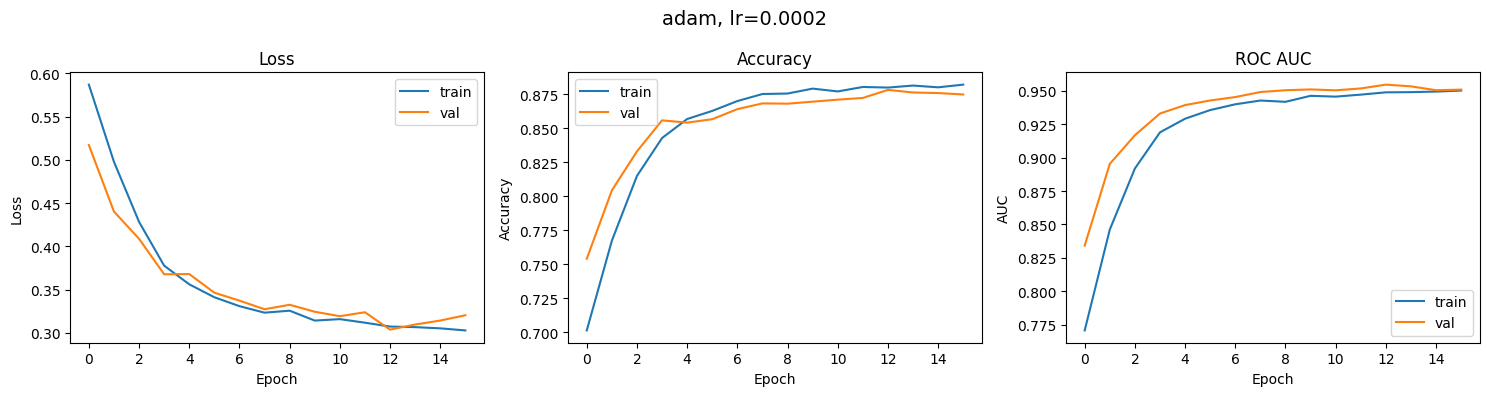

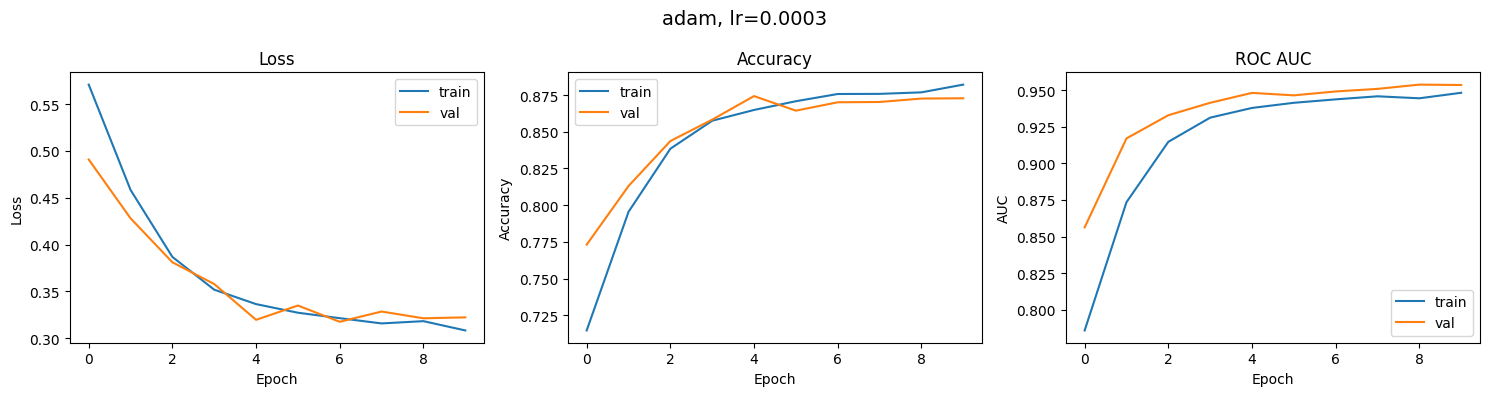

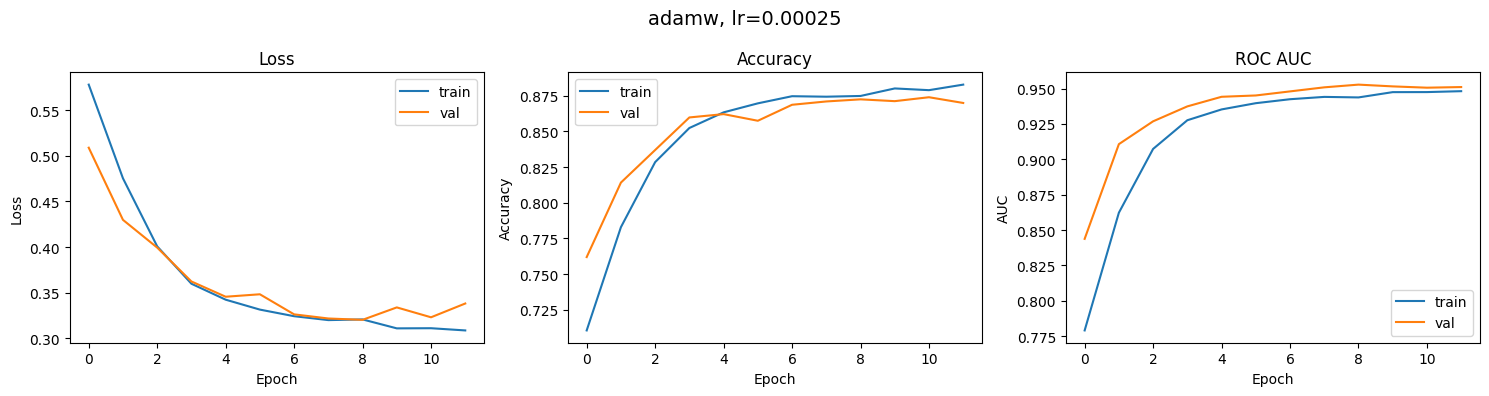

In [82]:
for (opt_name, lr), hist in histories1_gru.items():
    title = f"{opt_name}, lr={lr}"
    plot_history_dict(hist, title=title)

## Model Capacity Search

In [83]:
best_opt = "adam"
best_lr  = 2e-4

In [84]:
search_space2_gru = [
    (32, 64),
    (32, 32),
    (64, 128),
    (64, 64)
]

results2_gru = []
histories2_gru = {}

In [85]:
for gru_units, dense_units in search_space2_gru:

    print(f"\n===== Testing GRU={gru_units}, Dense={dense_units} =====")

    set_seed(42)

    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=gru_units,
        dense_units=dense_units,
        learning_rate=best_lr,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[es_gru]
    )

    res = evaluate_model_1(
    model=model,
    X=X_val_external,
    y=y_val_external,
    ids=val_ids,
    agg="mean")

    results2_gru.append((gru_units, dense_units, res["auc_sample"], res.get("auc_doc")))
    histories2_gru[(gru_units, dense_units)] = history.history


===== Testing GRU=32, Dense=64 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU=32, Dense=32 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU=64, Dense=128 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU=64, Dense=64 =====
[INFO] Seed set to 42, deterministic ops enabled


In [86]:
results2_gru_sorted = sorted(results2_gru, key=lambda x: x[3], reverse=True)  # sort by auc_sample

print("\n===== Summary of Capacity Search =====")
for gru_units, dense_units, auc_sample, auc_doc in results2_gru_sorted:
    print(f"GRU={gru_units:3d}, Dense={dense_units:3d}  "
          f"->  val_auc_sample={auc_sample:.4f}, val_auc_doc={auc_doc:.4f}")


===== Summary of Capacity Search =====
GRU= 32, Dense= 32  ->  val_auc_sample=0.7679, val_auc_doc=0.9300
GRU= 64, Dense= 64  ->  val_auc_sample=0.7776, val_auc_doc=0.9300
GRU= 32, Dense= 64  ->  val_auc_sample=0.7651, val_auc_doc=0.9200
GRU= 64, Dense=128  ->  val_auc_sample=0.7571, val_auc_doc=0.8900


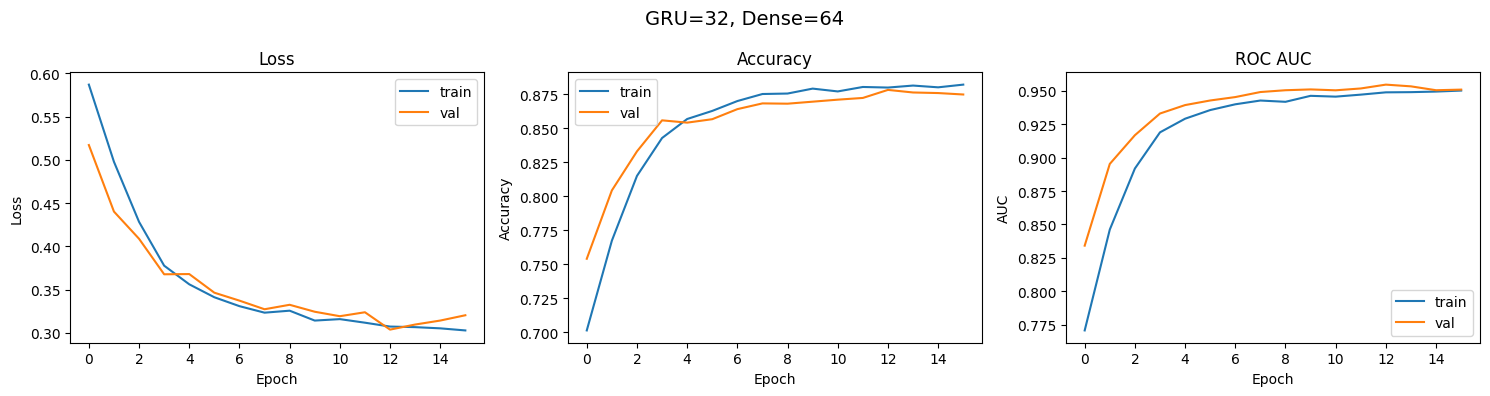

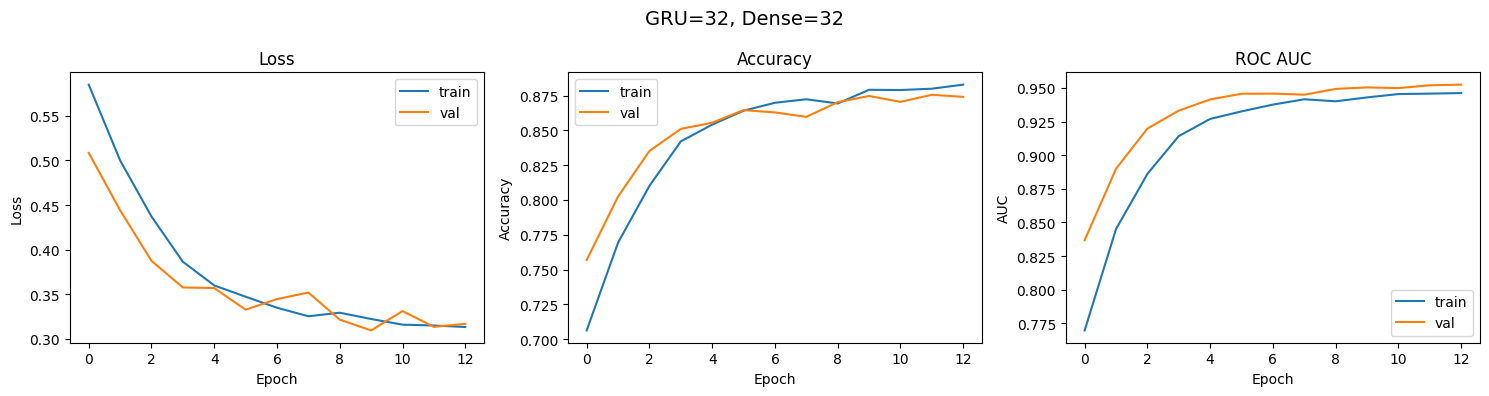

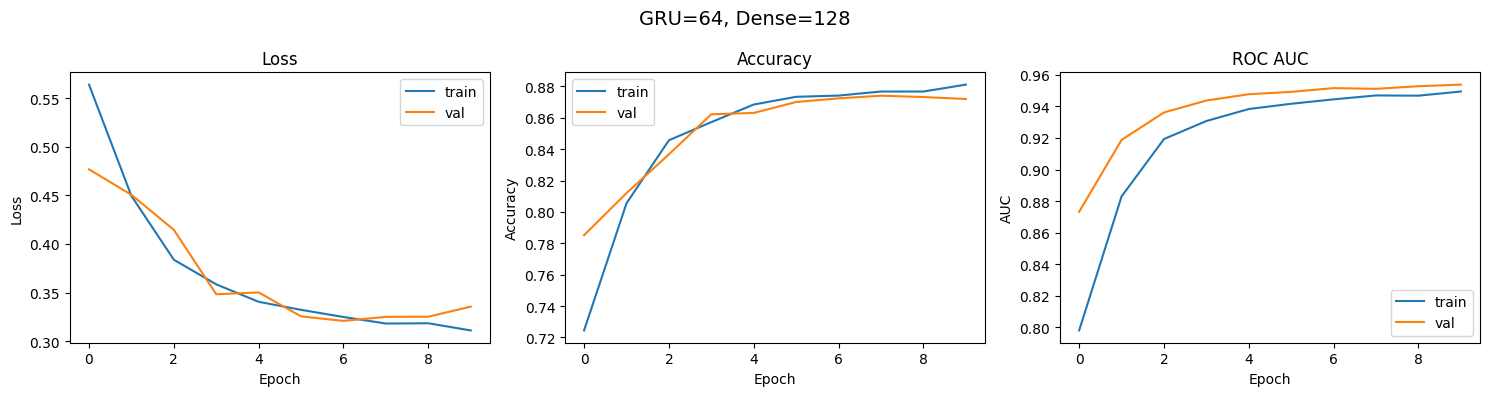

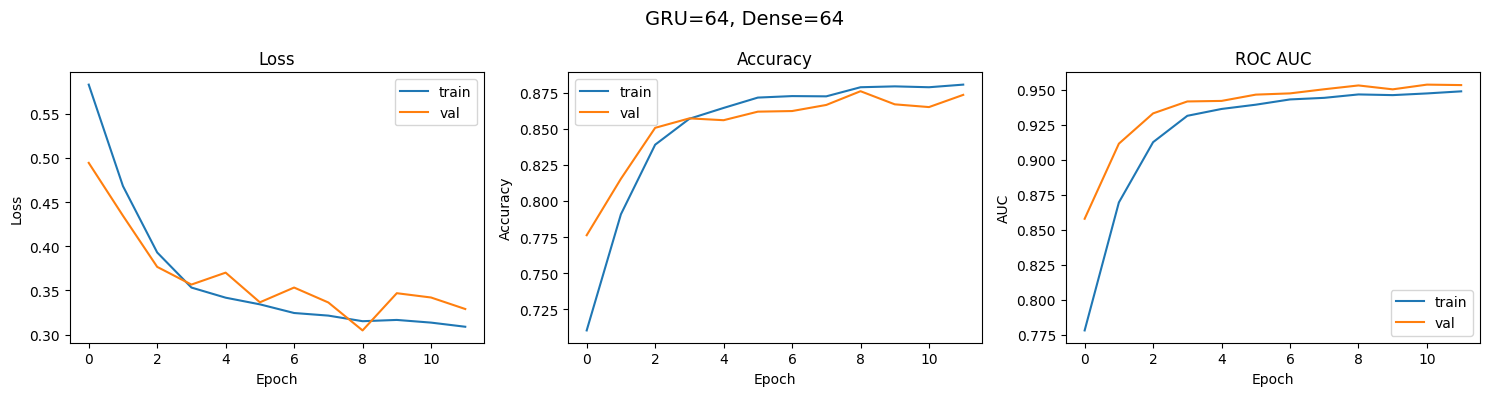

In [87]:
for (gru_units, dense_units), hist in histories2_gru.items():
    title = f"GRU={gru_units}, Dense={dense_units}"
    plot_history_dict(hist, title=title)

## Regularization Search

In [88]:
best_gru_units = 32
best_dense_units = 32

In [89]:
search_space3_gru = [
    (0.2, 0.4, 0.1, 1e-4),
    (0.2, 0.4, 0.1, 5e-4),
    (0.2, 0.4, 0.1, 5e-5),
    (0.3, 0.5, 0.1, 3e-4),
    (0.2, 0.3, 0.1, 8e-5)
]

results3_gru = []
histories3_gru = {}

In [90]:
for gru_do, dense_do, mha_do, l2reg in search_space3_gru:

    print(f"\n===== Testing GRU_dropout={gru_do}, Dense_dropout={dense_do}, "
          f"MHA_dropout={mha_do}, L2={l2reg} =====")

    set_seed(42)

    # build model (capacity fixed at chosen config, e.g. 32-32)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=gru_do,
        mha_dropout=mha_do,
        dense_units=best_dense_units,
        dense_dropout=dense_do,
        l2_reg=l2reg,
        learning_rate=best_lr,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=64,
        verbose=0,
        callbacks=[es_gru]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results3_gru.append((gru_do, dense_do, mha_do, l2reg, res["auc_sample"], res.get("auc_doc")))
    histories3_gru[(gru_do, dense_do, mha_do, l2reg)] = history.history


===== Testing GRU_dropout=0.2, Dense_dropout=0.4, MHA_dropout=0.1, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU_dropout=0.2, Dense_dropout=0.4, MHA_dropout=0.1, L2=0.0005 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU_dropout=0.2, Dense_dropout=0.4, MHA_dropout=0.1, L2=5e-05 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU_dropout=0.3, Dense_dropout=0.5, MHA_dropout=0.1, L2=0.0003 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing GRU_dropout=0.2, Dense_dropout=0.3, MHA_dropout=0.1, L2=8e-05 =====
[INFO] Seed set to 42, deterministic ops enabled


In [91]:
results3_gru_sorted = sorted(results3_gru, key=lambda x: x[5], reverse=True)

print("\n===== Summary of Regularization Search =====")
for gru_do, dense_do, mha_do, l2reg, auc_sample, auc_doc in results3_gru_sorted:
    print(
        f"GRU_do={gru_do:.2f}, Dense_do={dense_do:.2f}, "
        f"MHA_do={mha_do:.2f}, L2={l2reg:.1e}  "
        f"-> val_auc_sample={auc_sample:.4f}, val_auc_doc={auc_doc:.4f}"
    )


===== Summary of Regularization Search =====
GRU_do=0.20, Dense_do=0.40, MHA_do=0.10, L2=1.0e-04  -> val_auc_sample=0.7679, val_auc_doc=0.9300
GRU_do=0.20, Dense_do=0.40, MHA_do=0.10, L2=5.0e-04  -> val_auc_sample=0.7696, val_auc_doc=0.9300
GRU_do=0.20, Dense_do=0.40, MHA_do=0.10, L2=5.0e-05  -> val_auc_sample=0.7736, val_auc_doc=0.9300
GRU_do=0.20, Dense_do=0.30, MHA_do=0.10, L2=8.0e-05  -> val_auc_sample=0.7702, val_auc_doc=0.9300
GRU_do=0.30, Dense_do=0.50, MHA_do=0.10, L2=3.0e-04  -> val_auc_sample=0.7630, val_auc_doc=0.9100


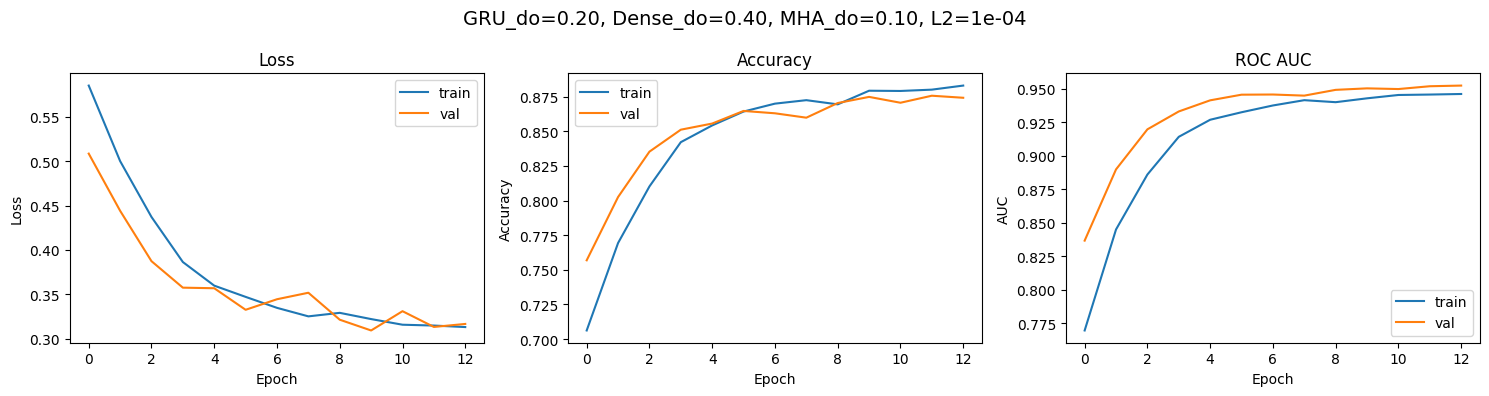

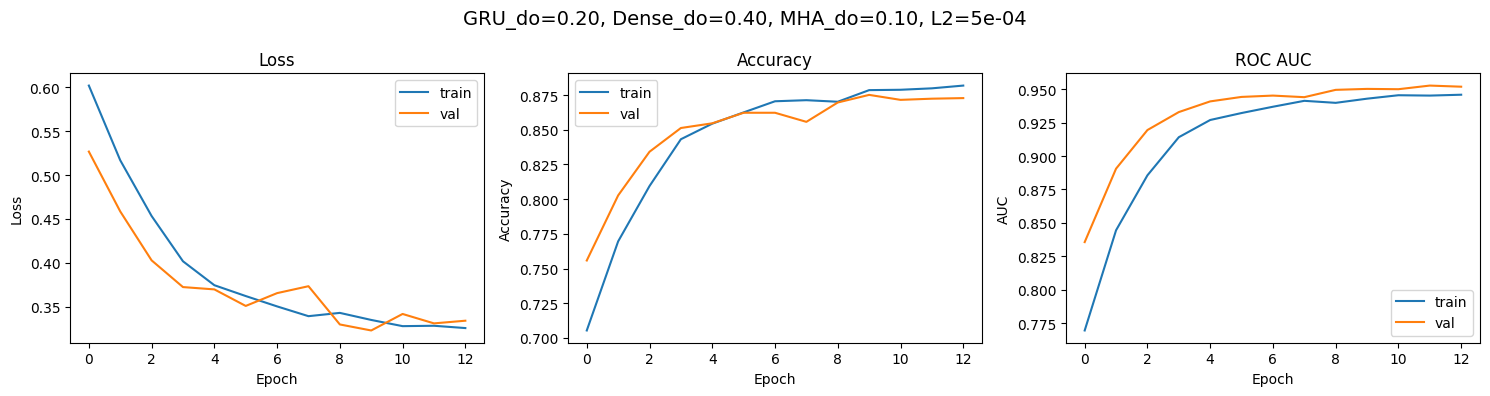

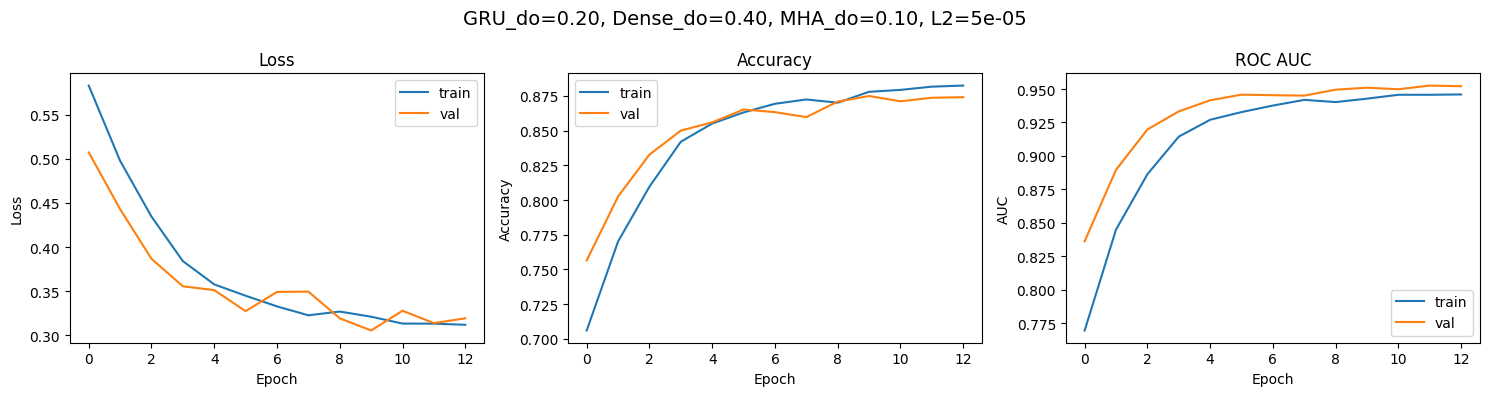

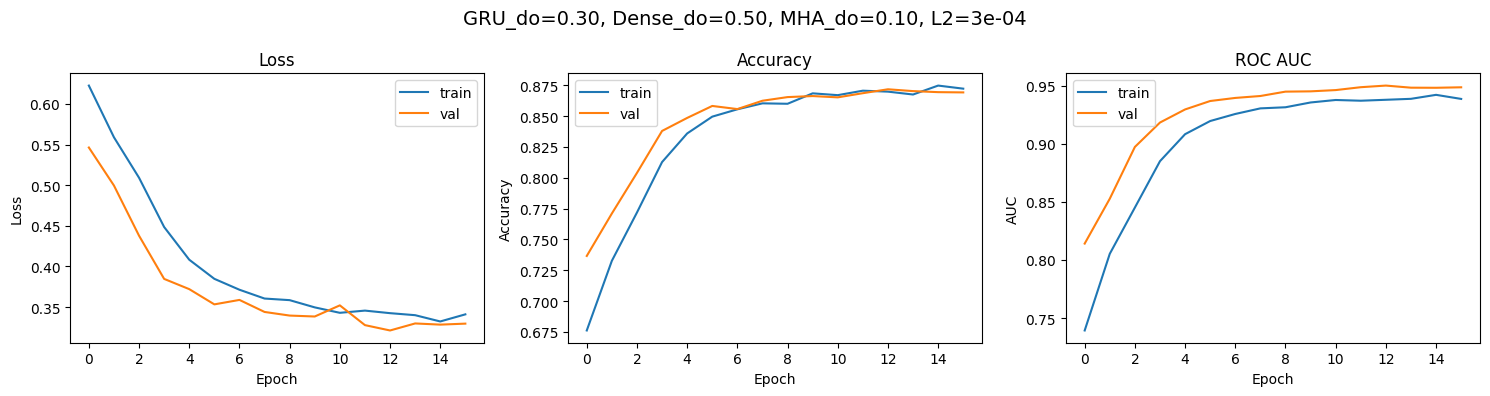

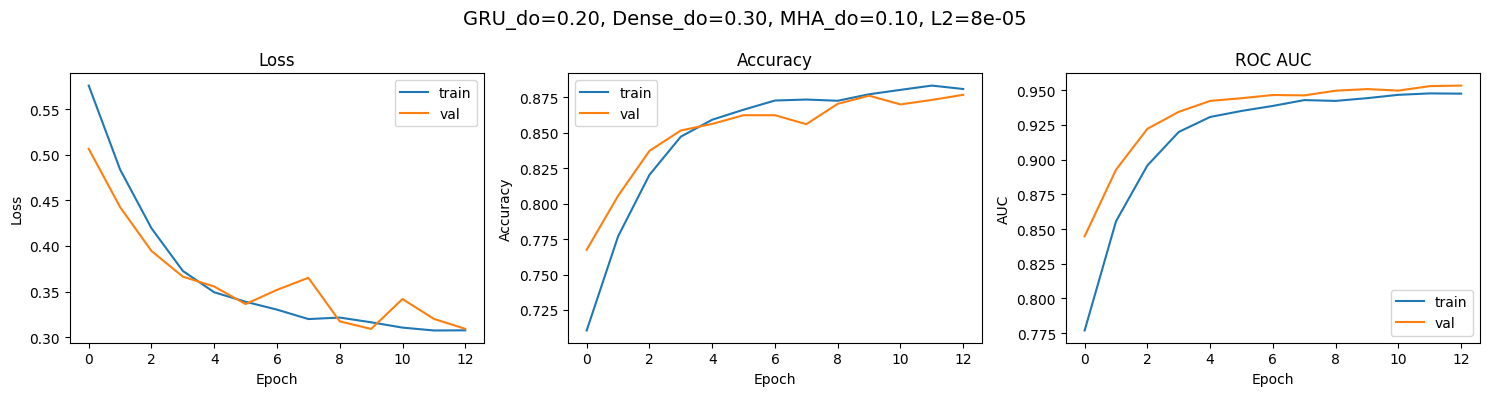

In [92]:
for (gru_do, dense_do, mha_do, l2reg), hist in histories3_gru.items():
    title = (
        f"GRU_do={gru_do:.2f}, "
        f"Dense_do={dense_do:.2f}, "
        f"MHA_do={mha_do:.2f}, "
        f"L2={l2reg:.0e}"
    )
    plot_history_dict(hist, title=title)

In [93]:
best_gru_dropout = 0.3
best_dense_dropout = 0.5
best_mha_dropout = 0.1
best_l2_reg = 3e-4

## Fine-tuning MHA Parameters

In [94]:
search_space4_gru = [
    (4, 16),
    (4, 32),
    (8, 16),
    (2, 32),
]

results4_gru = []
histories4_gru = {}

In [95]:
for mha_heads, mha_keydim in search_space4_gru:

    print(f"\n===== Testing MHA_heads={mha_heads}, MHA_keydim={mha_keydim} =====")

    set_seed(42)

    # build model (capacity + regularization fixed, only vary MHA)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=mha_heads,
        mha_keydim=mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=64,
        verbose=0,
        callbacks=[es_gru]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean")

    results4_gru.append((mha_heads, mha_keydim, res["auc_sample"], res.get("auc_doc")))
    histories4_gru[(mha_heads, mha_keydim)] = history.history


===== Testing MHA_heads=4, MHA_keydim=16 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing MHA_heads=4, MHA_keydim=32 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing MHA_heads=8, MHA_keydim=16 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing MHA_heads=2, MHA_keydim=32 =====
[INFO] Seed set to 42, deterministic ops enabled


In [96]:
results4_gru_sorted = sorted(results4_gru, key=lambda x: x[2], reverse=True)

print("\n===== Summary of MHA Parameter Search =====")
for heads, keydim, auc_sample, auc_doc in results4_gru_sorted:
    print(f"MHA_heads={heads:2d}, keydim={keydim:2d}  "
          f"->  val_auc_sample={auc_sample:.4f}, val_auc_doc={auc_doc:.4f}")


===== Summary of MHA Parameter Search =====
MHA_heads= 4, keydim=32  ->  val_auc_sample=0.7673, val_auc_doc=0.9200
MHA_heads= 8, keydim=16  ->  val_auc_sample=0.7653, val_auc_doc=0.9100
MHA_heads= 4, keydim=16  ->  val_auc_sample=0.7630, val_auc_doc=0.9100
MHA_heads= 2, keydim=32  ->  val_auc_sample=0.7546, val_auc_doc=0.9100


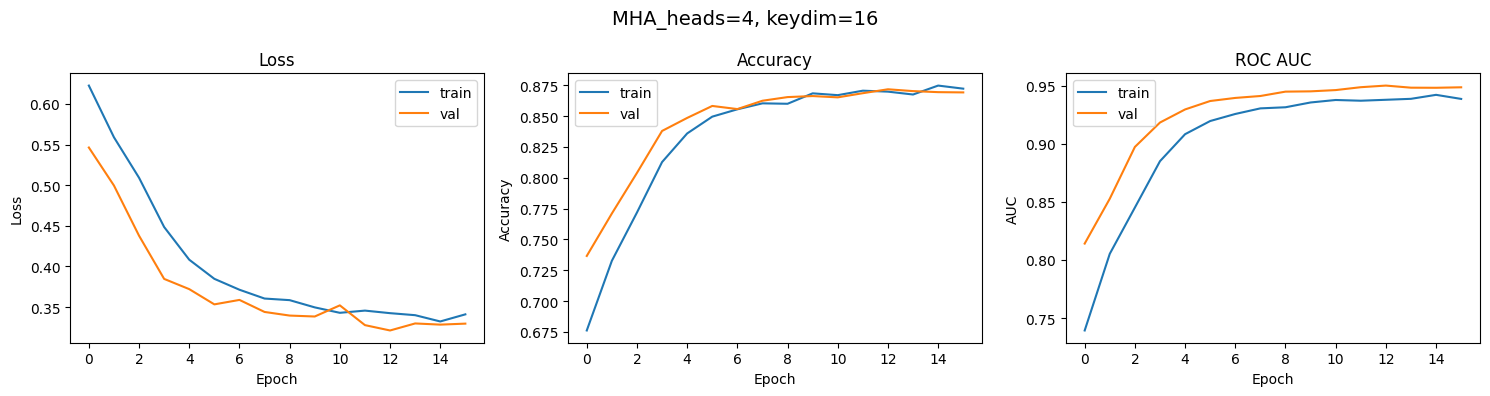

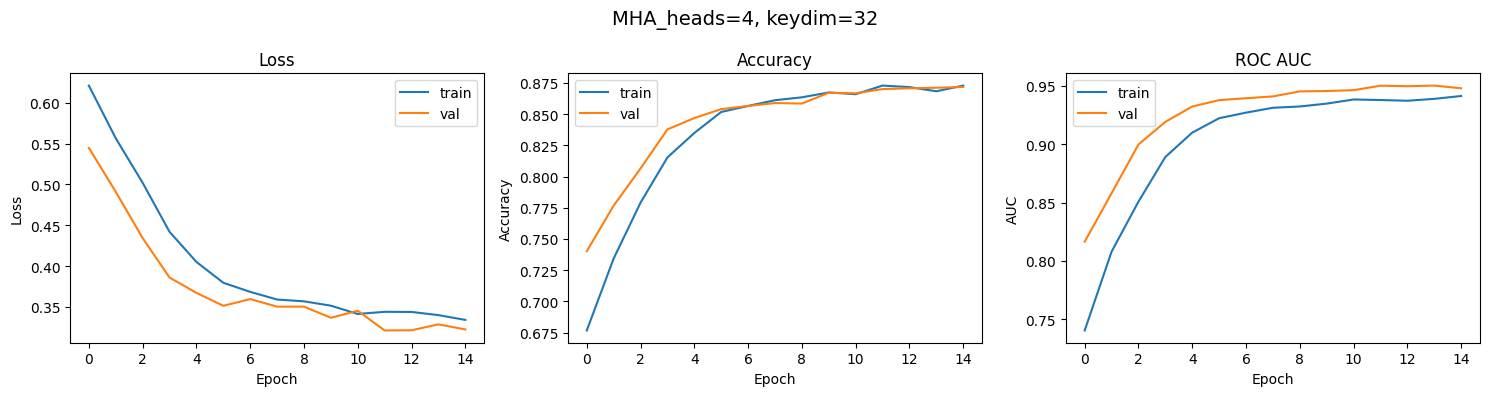

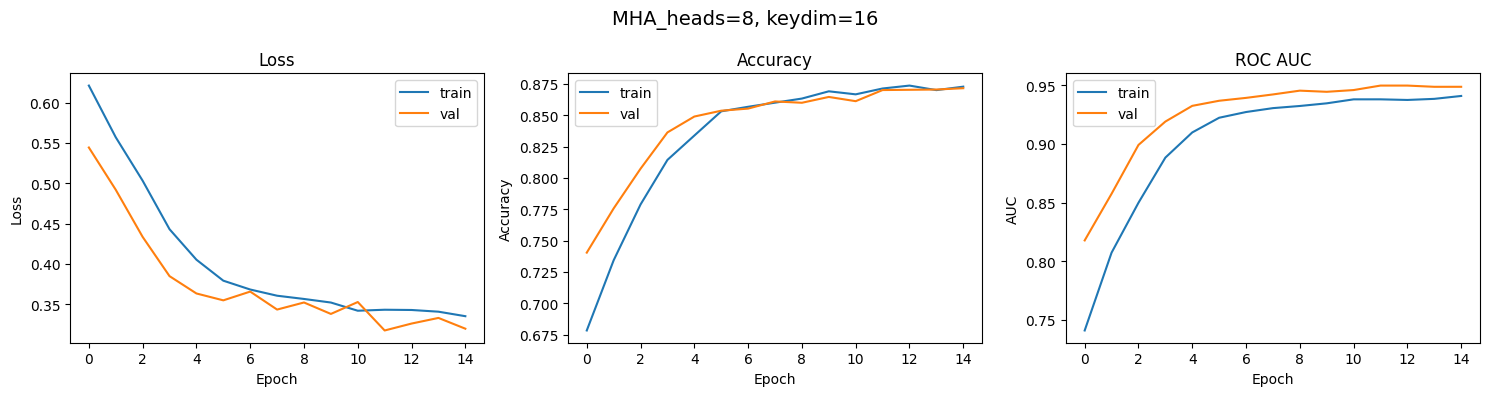

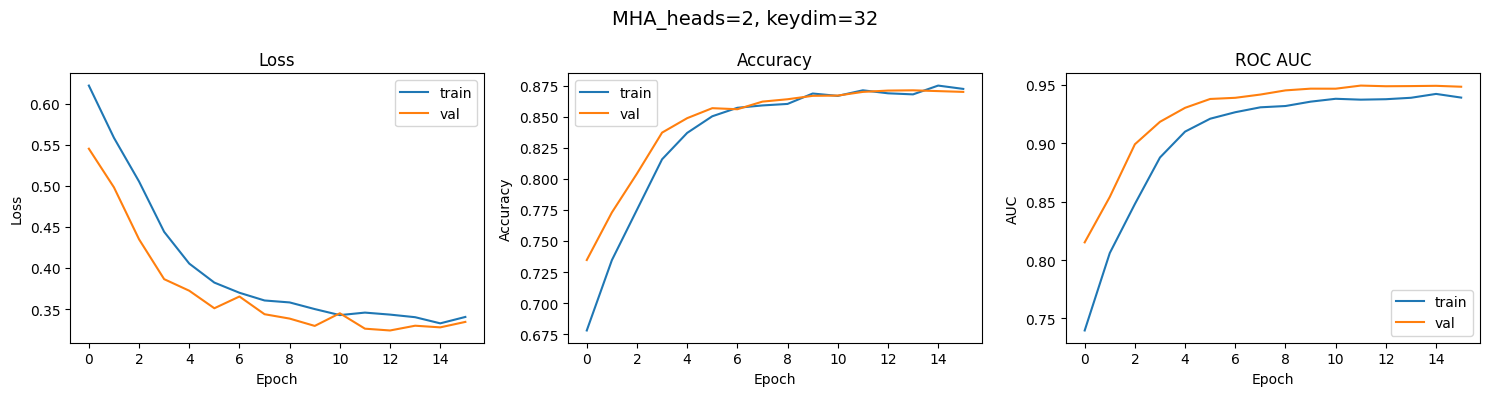

In [97]:
for (heads, keydim), hist in histories4_gru.items():
    title = f"MHA_heads={heads}, keydim={keydim}"
    plot_history_dict(hist, title=title)

## Label Smoothing Search

In [98]:
best_mha_heads = 4
best_mha_keydim = 32

In [99]:
search_space5_gru = [0.01, 0.1]

In [100]:
results5_gru = []
histories5_gru = {}

In [101]:
for ls in search_space5_gru:

    print(f"\n===== Testing Label Smoothing={ls} =====")

    set_seed(42)

    # build model (use best configs from previous steps)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=ls,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=64,
        verbose=0,
        callbacks=[es_gru]
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean")

    results5_gru.append((ls, res["auc_sample"], res.get("auc_doc")))
    histories5_gru[ls] = history.history


===== Testing Label Smoothing=0.01 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing Label Smoothing=0.1 =====
[INFO] Seed set to 42, deterministic ops enabled


In [102]:
results5_gru_sorted = sorted(results5_gru, key=lambda x: x[1], reverse=True)

print("\n===== Summary of Label Smoothing Search =====")
for ls, auc_sample, auc_doc in results5_gru_sorted:
    print(f"Label Smoothing={ls:.2f}  "
          f"->  val_auc_sample={auc_sample:.4f}, val_auc_doc={auc_doc:.4f}")


===== Summary of Label Smoothing Search =====
Label Smoothing=0.10  ->  val_auc_sample=0.7683, val_auc_doc=0.9200
Label Smoothing=0.01  ->  val_auc_sample=0.7673, val_auc_doc=0.9200


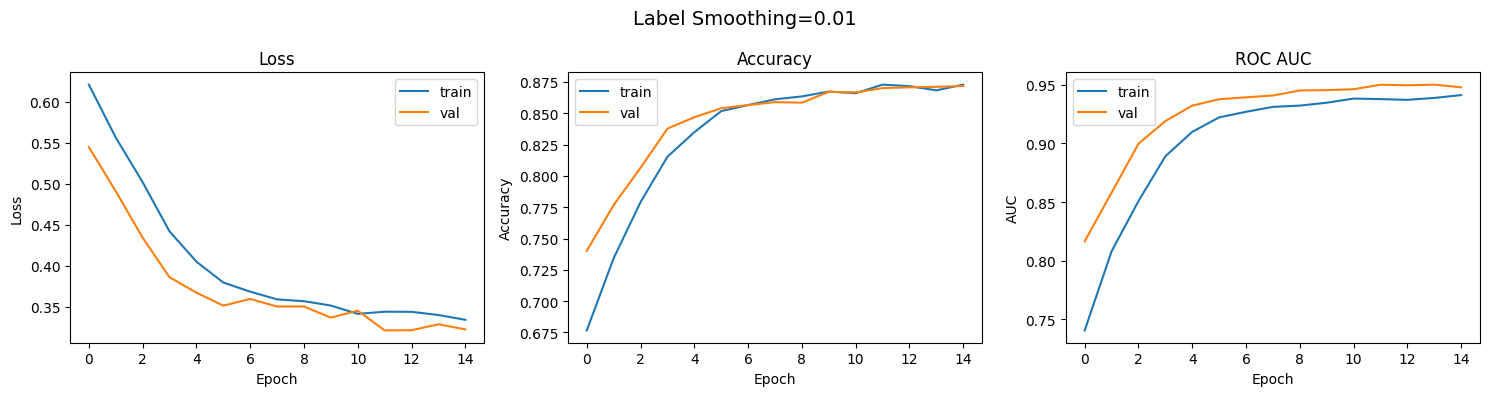

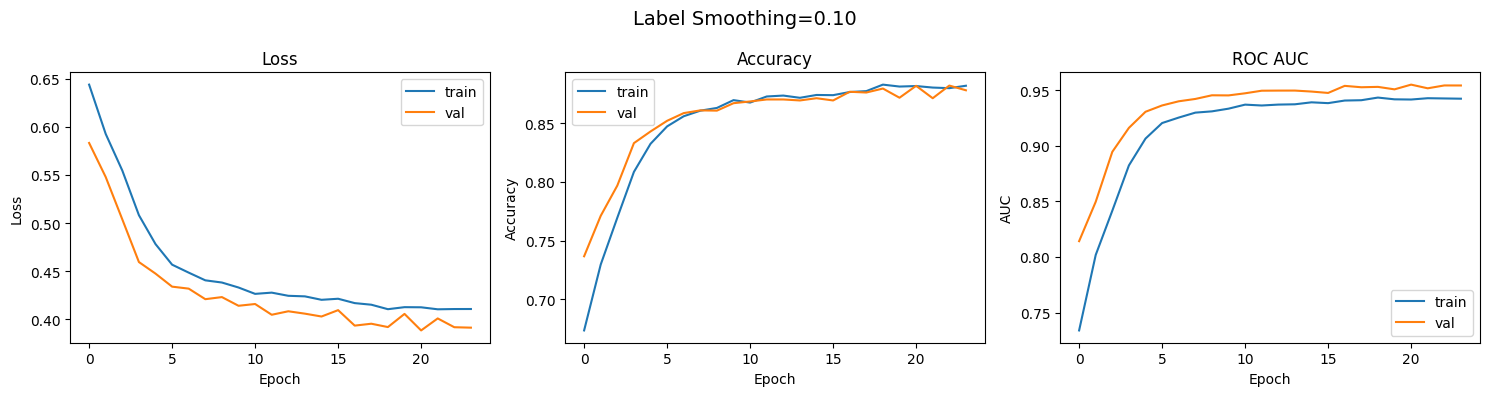

In [103]:
for ls, hist in histories5_gru.items():
    title = f"Label Smoothing={ls:.2f}"
    plot_history_dict(hist, title=title)

## Callbacks with Larger Early Stop Patience and LRreducer

In [104]:
best_ls = 0.1

In [105]:
cb_reduceLR = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
    )
]

cb_es = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

In [106]:
callback_sets_gru = {
    "earlystop_5": cb_es,
    "reduceLR+earlystop": cb_reduceLR
}

results6_gru = []
histories6_gru = {}

In [107]:
for name, cb in callback_sets_mlp.items():

    print(f"\n===== Testing callbacks: {name} =====")

    set_seed(42)

    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=best_ls,
        optimizer=best_opt
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=cb
    )

    res = evaluate_model_1(
        model=model,
        X=X_val_external,
        y=y_val_external,
        ids=val_ids,
        agg="mean"
    )

    results6_gru.append((name, res["auc_sample"], res.get("auc_doc")))
    histories6_gru[name] = history.history


===== Testing callbacks: earlystop_5 =====
[INFO] Seed set to 42, deterministic ops enabled

===== Testing callbacks: reduceLR+earlystop =====
[INFO] Seed set to 42, deterministic ops enabled


In [108]:
results6_gru_sorted = sorted(results6_gru, key=lambda x: x[1], reverse=True)
for name, auc_s, auc_d in results6_gru_sorted:
    print(f"{name:15s} -> val_auc_sample={auc_s:.4f}, val_auc_doc={auc_d:.4f}")

reduceLR+earlystop -> val_auc_sample=0.7734, val_auc_doc=0.9200
earlystop_5     -> val_auc_sample=0.7683, val_auc_doc=0.9200


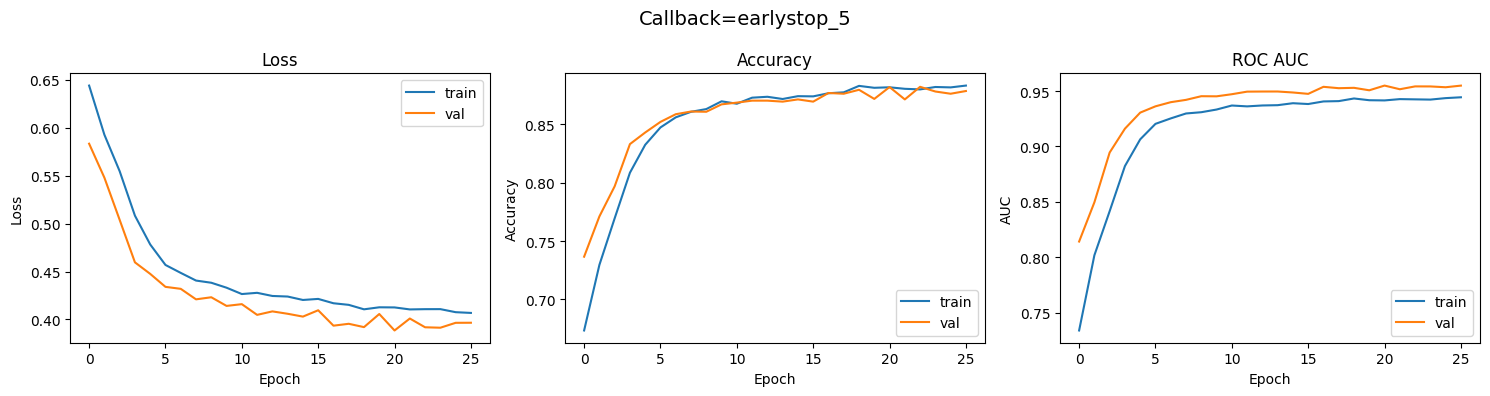

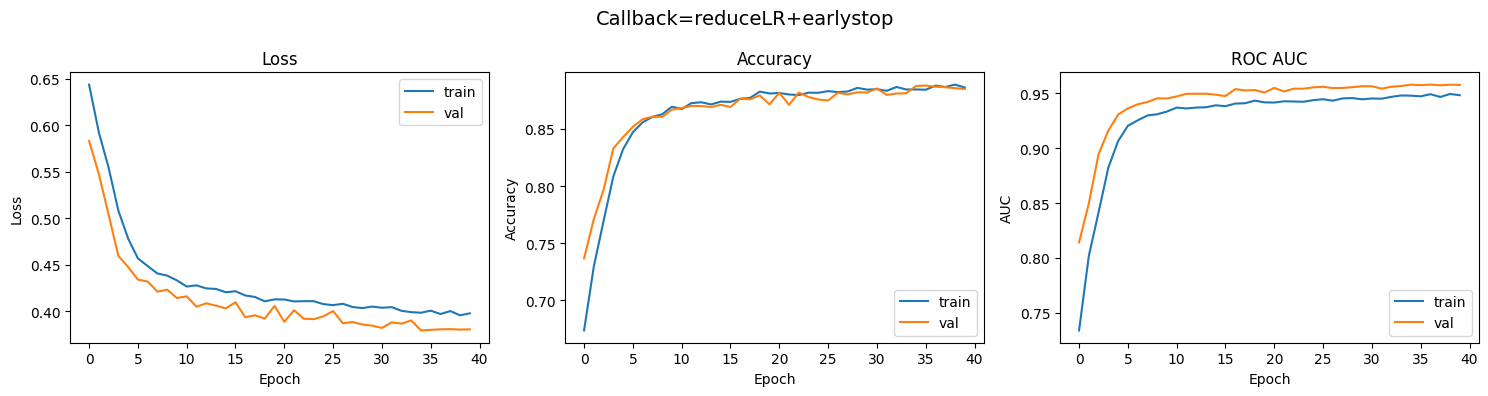

In [109]:
for name, hist in histories6_gru.items():
    plot_history_dict(hist, title=f"Callback={name}")

# Final BiGRU Model Training and Evaluation

In [110]:
best_gru_es = callback_sets_gru["reduceLR+earlystop"]

In [111]:
best_config_gru = {
    "gru_units": best_gru_units,
    "gru_dropout": best_gru_dropout,
    "mha_heads": best_mha_heads,
    "mha_keydim": best_mha_keydim,
    "mha_dropout": best_mha_dropout,
    "dense_units": best_dense_units,
    "dense_dropout": best_dense_dropout,
    "l2_reg": best_l2_reg,
    "learning_rate": best_lr,
    "label_smoothing": best_ls,
    "optimizer": best_opt
}

print("Best Config:")
for k, v in best_config_gru.items():
    print(f"  {k}: {v}")

Best Config:
  gru_units: 32
  gru_dropout: 0.3
  mha_heads: 4
  mha_keydim: 32
  mha_dropout: 0.1
  dense_units: 32
  dense_dropout: 0.5
  l2_reg: 0.0003
  learning_rate: 0.0002
  label_smoothing: 0.1
  optimizer: adam


In [112]:
set_seed(42)

final_gru = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=best_ls,
        optimizer=best_opt
    )

final_gru.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_74 (Lambda)  │ (None, 100)       │          0 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_21    │ (None, 100, 64)   │    153,984 │ input_layer_38[0… │
│ (Bidirectional)     │                   │            │ lambda_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_21         │ (None, 1, 1, 100) │          0 │ lambda_74[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     33,216 │ bidirectional_21… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_21… │
│                     │                   │            │ get_item_21[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 100, 64)   │          0 │ bidirectional_21… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 100, 64)   │          0 │ layer_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_75 (Lambda)  │ (None, 64)        │          0 │ spatial_dropout1… │
│                     │                   │            │ lambda_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 32)        │      2,080 │ lambda_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 32)        │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 1)         │         33 │ dropout_76[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,441 (740.00 KB)

 Trainable params: 189,441 (740.00 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
history = final_gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=best_gru_es
)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6363 - loss: 0.6918 - roc_auc: 0.6824 - val_accuracy: 0.7366 - val_loss: 0.5832 - val_roc_auc: 0.8142 - learning_rate: 2.0000e-04
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7186 - loss: 0.6035 - roc_auc: 0.7882 - val_accuracy: 0.7710 - val_loss: 0.5478 - val_roc_auc: 0.8496 - learning_rate: 2.0000e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7575 - loss: 0.5682 - roc_auc: 0.8272 - val_accuracy: 0.7968 - val_loss: 0.5038 - val_roc_auc: 0.8945 - learning_rate: 2.0000e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8024 - loss: 0.5171 - roc_auc: 0.8743 - val_accuracy: 0.8329 - val_loss: 0.4595 - val_roc_auc: 0.9161 - learning_rate: 2.0000e-04
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8266 - loss: 0.4850 - roc_auc: 0.9021 - val_accuracy: 0.8428 - val_loss: 0.4475 - val_roc_auc: 0.9305 - learning_rate: 2.0000e-04
Epoch 6/50
182

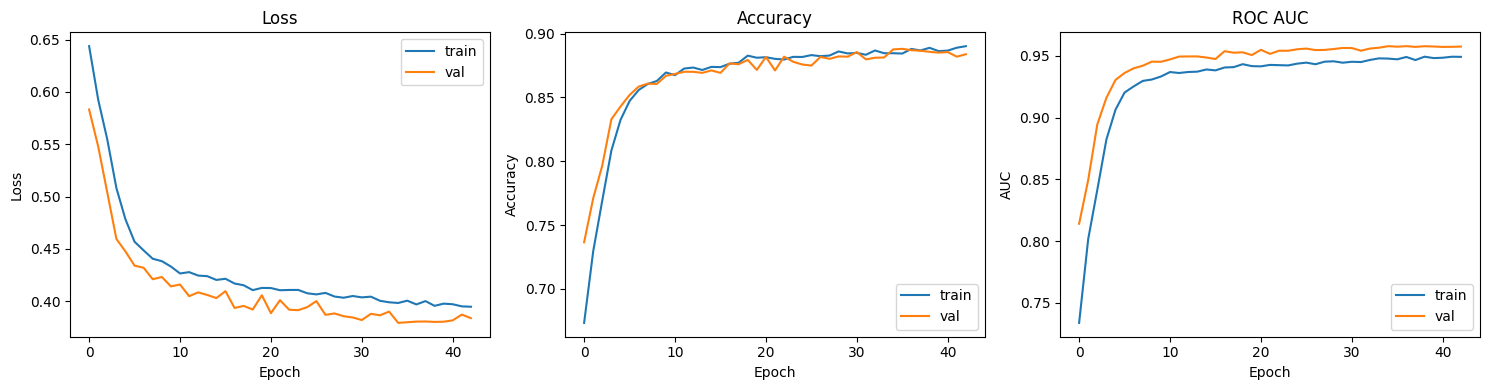

In [114]:
plot_history(history)

In [115]:
evaluate_model(model=final_gru, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

Sample-level AUROC: 0.7734
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.701     0.815     0.754       124
           1      0.697     0.552     0.616        96

    accuracy                          0.700       220
   macro avg      0.699     0.683     0.685       220
weighted avg      0.700     0.700     0.694       220

Doc-level AUROC (mean): 0.92


# Get Test Predictions by Final BiGRU

In [116]:
y_test_prob_gru = final_gru.predict(X_test).ravel()
df_probs_gru = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_gru})
final_probs_gru = df_probs_gru.groupby('id')['prob'].mean().reset_index()
print(final_probs_gru.head())

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
   id      prob
0  15  0.111077
1  16  0.225304
2  17  0.109424
3  18  0.387502
4  19  0.269104


In [117]:
out_dir = "/content/drive/MyDrive/my_exports"  # save to my google drive
os.makedirs(out_dir, exist_ok=True)

save_path = os.path.join(out_dir, "final_probs_gru.csv")
final_probs_gru.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/my_exports/final_probs_gru.csv


In [118]:
save_model(final_gru, base_name="final_gru")